<a href="https://colab.research.google.com/github/behzadhaki/dualization_dataset/blob/main/Dataset_Analyses_and_Generate_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is my analyses on the data collected.  It should be put under the dualization_dataset dir.  

It starts by defining different distances and metrics, and the intra-drummer and inter-drummer distance (with and without participant #2) is calculated.  Then different dualisations between participant is plotted as a heatmap, and also the heatmap distribution of the dualisations done by Behzad.  Lastly, the Instrument-Dualisation comparison will be done to see which instruments are extracted as the dualisation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing the required modules
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install pyfluidsynth pretty_midi

!pip install magenta
!pip install note_seq
!pip install tensorflow
!pip install python-Levenshtein

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 148489 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 6.1 MB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=91d2a9e08ef3dc52760914c89ae265da4367942ff449df3cda96b2d7569c3956
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a0647

In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Master thesis/dualization_dataset')

# Load Data

The [Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) is done by using the library [python-Levenshtein](https://pypi.org/project/python-Levenshtein/).  The [Spearman’s Rank Correlation](https://www.real-statistics.com/correlation/spearmans-rank-correlation/) directly to the loading data and calculation.

I am recording both correlation and p-value: correlation -1 ~ +1 where -1 is perfect negative correlation and +1 is perfect correlation; p-value < 0.01 is very strong correlation, and > 0.1 very weak

In [ ]:
from analysis.utils import midi_to_LeftRightHVO, midi_to_123format, cosine_distance, hamming_distance, convert_hvo_sequence_to_123format, midi_to_HVO

from hvo_sequence.hvo_seq import HVO_Sequence
import matplotlib.pyplot as plt

import os, glob

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [ ]:
%cd /content/drive/My Drive/Master thesis/dualization_dataset

/content/drive/My Drive/Master thesis/dualization_dataset


In [ ]:
# MAGENTA MAPPING
ROLAND_REDUCED_MAPPING = {
    "KICK": [36],
    "SNARE": [38, 37, 40],
    "HH_CLOSED": [42, 22, 44],
    "HH_OPEN": [46, 26],
    "TOM_3_LO": [43, 58],
    "TOM_2_MID": [47, 45],
    "TOM_1_HI": [50, 48],
    "CRASH": [49, 52, 55, 57],
    "RIDE":  [51, 53, 59]
}

First I add the Jaccard index to take 2 123format and calculate the result.  In 123format, 0 is no hits (NH), 1 and 2 are single hits (SH), and 3 is a double hit (DH).  After getting this result, the union and the intersection of the 2 arrays will be compared.

In [ ]:
def transform_123_to_XH(_123format_data):
  '''
  This function accepts a list or np array in 123 format, where every element is a float,
  and transform it into NH, SH, or DH.
  '''
  XH_format_data = []
  for beat in _123format_data:
    if beat == 0.0:
      XH_format_data.append('NH')
    elif beat == 1.0 or beat == 2.0:
      XH_format_data.append('SH')
    elif beat == 3.0:
      XH_format_data.append('DH')
    else:
      raise ValueError('123 format is wrong')
  return XH_format_data

# # EXAMPLE 
# # The result should be ['NH', 'SH', 'SH', 'DH']
# data_in_123format = [0.0, 1.0, 2.0, 3.0]
# print(transform_123_to_XH(data_in_123format))

################################################################################

def add_timestamp_to_XH_format_data(XH):
  '''
  This function adds a timestamp for each element in the list.
  '''
  XH_with_timestamp = []
  for i in range(len(XH)):
    XH_with_timestamp.append(XH[i] + str(i))
  return XH_with_timestamp

# # EXAMPLE
# # The result should be ['NH0', 'SH1', 'SH2', 'DH3']
# print(add_timestamp_to_XH_format_data(['NH', 'SH', 'SH', 'DH']))

################################################################################

def remove_NH_items_from_list(XH_list):
  '''
  This function removes any list that starts with NH.
  '''
  XH_filtered = []
  for element in XH_list:
    if not element.startswith('NH'):
      XH_filtered.append(element)
  return XH_filtered

# # EXAMPLE
# # Result should be ['SH1', 'SH2', 'DH3']
# XH_list = ['NH0', 'SH1', 'SH2', 'DH3', 'NH4']
# print(remove_NH_items_from_list(XH_list))

################################################################################

def union_of_2_lists(list1, list2):
  '''
  This function returns the union of 2 lists (so the denominator in the Jaccard index equation)
  The union is not sorted
  '''
  return list(set().union(list1,list2))

# # EXAMPLE
# # The result should be containing a b c d e f g in some order
# # In the colab it is ['g', 'e', 'a', 'd', 'b', 'f', 'c'] 
# list1 = ['a','b','c','d']
# list2 = ['a','b','e','f','g']
# print(union_of_2_lists(list1, list2))

################################################################################

def intersection_of_2_lists(list1, list2):
  '''
  This function returns the intersection of 2 lists (so the numerator in the Jaccard index equation)
  The result is not sorted
  '''
  return list(set(list1) & set(list2))

# # EXAMPLE
# # The result should be containing a b in some order
# # In the colab it is ['b', 'a']
# list1 = ['a','b','c','d']
# list2 = ['a','b','e','f','g']
# print(intersection_of_2_lists(list1, list2))

################################################################################

def jaccard_index_of_2_123format_data(_123format_data_1, _123format_data_2):
  '''
  This function calculates the jaccard index of 2 hits data in the 123format.
  '''
  XH1 = transform_123_to_XH(_123format_data_1)
  XH2 = transform_123_to_XH(_123format_data_2)

  XH1 = add_timestamp_to_XH_format_data(XH1)
  XH2 = add_timestamp_to_XH_format_data(XH2)

  #print(intersection_of_2_lists(XH1, XH2))
  #print(union_of_2_lists(XH1, XH2))
  intersection_size = len(intersection_of_2_lists(XH1, XH2))
  union_size = len(union_of_2_lists(XH1, XH2)) 
  return intersection_size / union_size

# # EXAMPLE
# # The first example is the 2 4-length dualisation in the meeting with Behzad
# print('Example 1:')
# _123format_data_1 = [1.0, 2.0, 0.0, 3.0]
# _123format_data_2 = [2.0, 1.0, 1.0, 0.0]
# print('123format 1 is: ', _123format_data_1)
# print('123format 2 is: ', _123format_data_2)
# print('jaccard index is ', jaccard_index_of_2_123format_data(_123format_data_1, _123format_data_2))

# # Second example is the jaccard distance of 2 tracks from the data.
# print('\n\n\nExample 2:')
# _123format_data_1 = squeezed_123format_data[unique_files_tested_from_gmd[0]][drummers[0]][0]
# _123format_data_2 = squeezed_123format_data[unique_files_tested_from_gmd[0]][drummers[0]][1]
# print('123format 1 is: ', _123format_data_1)
# print('123format 2 is: ', _123format_data_2)
# print('jaccard index is ', jaccard_index_of_2_123format_data(_123format_data_1, _123format_data_2))

Here I add the [Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) using the library [python-Levenshtein](https://pypi.org/project/python-Levenshtein/).

In [ ]:
# Adding the Levenshtein Distance
import Levenshtein
import numpy as np
import random

def decimal_list_to_string(original_list):
  '''
  This function takes the number of the 1st decimal and combine it into a long string.
  As every velocity is a float from 0 - 1, it needs some preprocess before plugging in the 
  Levenshtein distance directly.
  I extract the 1st digit behind the decimal point and string them together and form a new string.  
  '''
  original_list = original_list.tolist()
  string = ''
  for characters in original_list:
    string = string + str(characters)[2]
  return string

# # EXAMPLE
# # Result should be '03338'
# print(decimal_list_to_string(np.array([0.0,0.31,0.35,0.33333,0.89])))

################################################################################

def string_to_zeros_and_ones(number_string):
  final_string = ''
  for character in number_string:
    number_of_ones = int(character)
    number_of_zeros = 10 - number_of_ones
    final_string = final_string + '0' * number_of_zeros + '1' * number_of_ones
  return final_string

# # EXAMPLE
# # Result should be 0000000000 0000011111 0111111111
# number_string = '059'
# print(string_to_zeros_and_ones(number_string))

################################################################################

def levenshtein_distance(vels1, vels2, hits1=None, hits2=None):
  '''
  This function calculates the levenshtein distance between 2 tracks,
  it can handle either velocity only or both the data.
  '''
  vels1_str = string_to_zeros_and_ones(decimal_list_to_string(vels1))
  vels2_str = string_to_zeros_and_ones(decimal_list_to_string(vels2))

  if hits1 is None and hits2 is None:
    return Levenshtein.distance(vels1_str, vels2_str)
  else:
    hits1 = hits1.astype(int).astype(str).tolist()
    hits2 = hits2.astype(int).astype(str).tolist()
    return Levenshtein.distance(vels1_str, vels2_str), Levenshtein.distance(''.join(hits1), ''.join(hits2))


# # EXAMPLE
# # First result should be a tuple of (9,4)
# # Second one should be 9
# vels1 = squeezed_velocity_groove_data[unique_files_tested_from_gmd[0]][drummers[0]][0]
# vels2 = squeezed_velocity_groove_data[unique_files_tested_from_gmd[0]][drummers[0]][1]
# hits1 = squeezed_123format_data[unique_files_tested_from_gmd[0]][drummers[0]][0]
# hits2 = squeezed_123format_data[unique_files_tested_from_gmd[0]][drummers[0]][1]
# print(levenshtein_distance(vels1, vels2, hits1, hits2))
# print(levenshtein_distance(vels1, vels2))

Here I add the [Lerdahl and Jackendoff metrical structure](https://www.researchgate.net/figure/The-metrical-structure-of-Lerdahl-and-Jackendoff-16-for-a-16-pulse-timeline_fig1_279235158) as a mask to the tracks.  Now it only applies to velocity as I don't think applying onto hits makes any sense.  If the APPLY_METRICAL_STRUCTURE_TO_VELS = True, the metrical_structure list of 32 will be multiplied into the velocity while loading the data.

In [ ]:
# Adding the Lerdahl and Jackendoff metrical structure
# len = 32 because 2 bars
import numpy as np

APPLY_METRICAL_STRUCTURE_TO_VELS = True

# This is the Lerdahl Profile 
metrical_structure = [1.0, 0.2, 0.4, 0.2, 0.6, 0.2, 0.4, 0.2, 0.8, 0.2, 0.4, 0.2, 0.6, 0.2, 0.4, 0.2,\
                      1.0, 0.2, 0.4, 0.2, 0.6, 0.2, 0.4, 0.2, 0.8, 0.2, 0.4, 0.2, 0.6, 0.2, 0.4, 0.2]

# # And this is the Palmer Profile
# metrical_structure = [1.0, 0.67, 0.7, 0.58, 0.95, 0.5, 0.75, 0.58, 0.9, 0.45, 0.5, 0.52, 0.87, 0.55, 0.75, 0.7,\
#                       1.0, 0.67, 0.7, 0.58, 0.95, 0.5, 0.75, 0.58, 0.9, 0.45, 0.5, 0.52, 0.87, 0.55, 0.75, 0.7]


A randomisation is added here for every available distances.  It is guaranteed that both randomly selected tracks were not from the same track, i.e. that they have a different original track.

In [ ]:
def get_randomised_distances(num_rep):
  '''
  This function returns all the distances with random tracks
  It is ensured that each comparison is from 2 different tracks
  However it is written very dumb and not convenient to expand on if you want to add new distances...
  '''
  random_cosine_distances = []
  random_hamming_distances = []
  random_cosine_distances_vels = []
  random_hamming_distances_vels = []
  random_levenshtein_distances_hits = []
  random_levenshtein_distances_vels = []
  random_spearmanr_corr_hits = []
  random_spearmanr_corr_vels = []
  random_spearmanr_p_hits = []
  random_spearmanr_p_vels = []
  random_autocorr_hits = []
  random_autocorr_vels = []
  random_jaccard = []

  random.seed(12345)
  for i in range(num_rep):
    i1 = random.randint(0,23)
    j1 = random.randint(0,4)
    k1 = random.randint(0,2)

    i2 = random.randint(0,23)
    j2 = random.randint(0,4)
    k2 = random.randint(0,2)

    while i1 == i2:
      i2 = random.randint(0,23)
    
    random_123format_1 = squeezed_123format_data[unique_files_tested_from_gmd[i1]][drummers[j1]][k1]
    random_123format_2 = squeezed_123format_data[unique_files_tested_from_gmd[i2]][drummers[j2]][k2]

    random_velocity_groove_1 = squeezed_velocity_groove_data[unique_files_tested_from_gmd[i1]][drummers[j1]][k1]
    random_velocity_groove_2 = squeezed_velocity_groove_data[unique_files_tested_from_gmd[i2]][drummers[j2]][k2]

    random_cosine_distances.append(cosine_distance(random_123format_1,random_123format_2))
    random_hamming_distances.append(hamming_distance(random_123format_1,random_123format_2))
    random_cosine_distances_vels.append(cosine_distance(random_velocity_groove_1,random_velocity_groove_2))
    random_hamming_distances_vels.append(hamming_distance(random_velocity_groove_1,random_velocity_groove_2))

    random_spearmanr_corr_hits.append(stats.spearmanr(random_123format_1,random_123format_2)[0])
    random_spearmanr_corr_vels.append(stats.spearmanr(random_velocity_groove_1,random_velocity_groove_2)[0])
    random_spearmanr_p_hits.append(stats.spearmanr(random_123format_1,random_123format_2)[1])
    random_spearmanr_p_vels.append(stats.spearmanr(random_velocity_groove_1,random_velocity_groove_2)[1])
    

    lvd_vels, lvd_hits = levenshtein_distance(random_velocity_groove_1, random_velocity_groove_2,\
                                              hits1=random_123format_1, hits2=random_123format_2)
    random_levenshtein_distances_hits.append(lvd_hits)
    random_levenshtein_distances_vels.append(lvd_vels)

    random_autocorr_hits.append(np.correlate(random_123format_1,random_123format_2).sum())
    random_autocorr_vels.append(np.correlate(random_velocity_groove_1,random_velocity_groove_2).sum())

    random_jaccard.append(jaccard_index_of_2_123format_data(random_123format_1,random_123format_2))

  random_spearmanr_corr_hits = [x for x in random_spearmanr_corr_hits if str(x) != 'nan']
  random_spearmanr_corr_vels = [x for x in random_spearmanr_corr_vels if str(x) != 'nan']
  random_spearmanr_p_hits = [x for x in random_spearmanr_p_hits if str(x) != 'nan']
  random_spearmanr_p_vels = [x for x in random_spearmanr_p_vels if str(x) != 'nan']

  return random_cosine_distances, random_hamming_distances, random_levenshtein_distances_hits, random_levenshtein_distances_vels,\
  random_spearmanr_corr_hits, random_spearmanr_corr_vels, random_spearmanr_p_hits, random_spearmanr_p_vels,\
  random_autocorr_hits, random_autocorr_vels, random_jaccard, random_cosine_distances_vels, random_hamming_distances_vels

Here I add the [Spearman’s Rank Correlation](https://www.real-statistics.com/correlation/spearmans-rank-correlation/) directly to the loading data and calculation.

I am recording both correlation and p-value: correlation -1 ~ +1 where -1 is perfect negative correlation and +1 is perfect correlation; p-value < 0.01 is very strong correlation, and > 0.1 very weak

In [ ]:
import pretty_midi
import note_seq
from hvo_sequence.io_helpers import *
import tqdm
import numpy as np
from scipy import stats

# get drummers and filenames
root_data_dir = "processed_data/InterDrummer_Repetitions"
drummers = ["genis", "ignasi", "morgan", "pau", "luis"]
original_fname = "original.mid"
repetition_fnames = ["repetition_0.mid", "repetition_1.mid", "repetition_2.mid"]

unique_files_tested_from_gmd = [x.split("/")[-1] for x in glob.glob(os.path.join(root_data_dir, drummers[0], "*"))]

# Load Data
hvo_seq_data = {x: {} for x in unique_files_tested_from_gmd}
#ori_hvo_seq_data = {x: {} for x in unique_files_tested_from_gmd}
hits_data = {x: {} for x in unique_files_tested_from_gmd}
squeezed_123format_data = {x: {} for x in unique_files_tested_from_gmd}
squeezed_velocity_groove_data = {x: {} for x in unique_files_tested_from_gmd}

intra_drummer_cosine_distances = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_hamming_distances = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_cosine_distances_vels = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_hamming_distances_vels = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_levenshtein_distances_hits = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_levenshtein_distances_vels = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_spearmanr_corr_hits = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_spearmanr_corr_vels = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_spearmanr_p_hits = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_spearmanr_p_vels = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_autocorr_hits = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_autocorr_vels = {x: {} for x in unique_files_tested_from_gmd}
intra_drummer_jaccard = {x: {} for x in unique_files_tested_from_gmd}

# Load Data
for drummer in tqdm.tqdm(drummers):

    for unique_file_tested_from_gmd in unique_files_tested_from_gmd:

        hvo_seqs_repeated = []  # contains the hvo_sequence instances
        hits_repeated = []  # each entry has shape (32, 2)
        squeezed_123_repeated = []  # converted to 1, 2, 3 format
        squeezed_velocity_groove_repeated = []  # tappified left/right (only velocity)

        cosine_distances = []
        hamming_distances = []
        cosine_distances_vels = []
        hamming_distances_vels = []
        levenshtein_distances_hits = []
        levenshtein_distances_vels = []
        spearmanr_corr_hits = []
        spearmanr_corr_vels = []
        spearmanr_p_hits = []
        spearmanr_p_vels = []
        autocorr_hits = []
        autocorr_vels = []
        jaccard = []

        for repetition_fname in repetition_fnames:
            midi_filename = os.path.join(root_data_dir, drummer, unique_file_tested_from_gmd, repetition_fname)
            hvo_seq = midi_to_LeftRightHVO(midi_filename)
            hvo_seqs_repeated.append(hvo_seq)
            hits_repeated.append(hvo_seq.get("h"))
            squeezed_123_repeated.append(convert_hvo_sequence_to_123format(hvo_seq))
            velocities = hvo_seq.flatten_voices(voice_idx=0)[:, 2]
            # Applying the Lerdahl and Jackendoff if toggled
            if APPLY_METRICAL_STRUCTURE_TO_VELS == True:
              velocities = np.multiply(velocities,metrical_structure)
            squeezed_velocity_groove_repeated.append(velocities)

        


        hvo_seq_data[unique_file_tested_from_gmd][drummer] = hvo_seqs_repeated
        hits_data[unique_file_tested_from_gmd][drummer] = hits_repeated
        squeezed_123format_data[unique_file_tested_from_gmd][drummer] = squeezed_123_repeated
        squeezed_velocity_groove_data[unique_file_tested_from_gmd][drummer] = squeezed_velocity_groove_repeated

        # calculate distances
        for idx0 in range(len(squeezed_123_repeated)):
            for idx1 in range(idx0+1, len(squeezed_123_repeated)):
                #print(type(squeezed_123_repeated[idx0]))
                #print(list_to_string(squeezed_123_repeated[idx0]))
                #print(Levenshtein.distance(list_to_string(squeezed_123_repeated[idx0]), list_to_string(squeezed_123_repeated[idx1])))
                cosine_distances.append(cosine_distance(squeezed_123_repeated[idx0], squeezed_123_repeated[idx1]))
                hamming_distances.append(hamming_distance(squeezed_123_repeated[idx0], squeezed_123_repeated[idx1]))
                cosine_distances_vels.append(cosine_distance(squeezed_velocity_groove_repeated[idx0], squeezed_velocity_groove_repeated[idx1]))
                hamming_distances_vels.append(hamming_distance(squeezed_velocity_groove_repeated[idx0], squeezed_velocity_groove_repeated[idx1]))
                spearmanr_corr_hits.append(stats.spearmanr(squeezed_123_repeated[idx0], squeezed_123_repeated[idx1])[0])
                spearmanr_corr_vels.append(stats.spearmanr(squeezed_velocity_groove_repeated[idx0], squeezed_velocity_groove_repeated[idx1])[0])
                spearmanr_p_hits.append(stats.spearmanr(squeezed_123_repeated[idx0], squeezed_123_repeated[idx1])[1])
                spearmanr_p_vels.append(stats.spearmanr(squeezed_velocity_groove_repeated[idx0], squeezed_velocity_groove_repeated[idx1])[1])

                lvdv, lvdh = levenshtein_distance(squeezed_velocity_groove_repeated[idx0], squeezed_velocity_groove_repeated[idx1],\
                                                  squeezed_123_repeated[idx0], squeezed_123_repeated[idx1])
                levenshtein_distances_hits.append(lvdh)
                levenshtein_distances_vels.append(lvdv)
                autocorr_hits.append(np.correlate(squeezed_123_repeated[idx0], squeezed_123_repeated[idx1]).sum())
                autocorr_vels.append(np.correlate(squeezed_velocity_groove_repeated[idx0], squeezed_velocity_groove_repeated[idx1]).sum())
                jaccard.append(jaccard_index_of_2_123format_data(squeezed_123_repeated[idx0], squeezed_123_repeated[idx1]))

        intra_drummer_cosine_distances[unique_file_tested_from_gmd][drummer] = cosine_distances
        intra_drummer_hamming_distances[unique_file_tested_from_gmd][drummer] = hamming_distances
        intra_drummer_cosine_distances_vels[unique_file_tested_from_gmd][drummer] = cosine_distances_vels
        intra_drummer_hamming_distances_vels[unique_file_tested_from_gmd][drummer] = hamming_distances_vels
        intra_drummer_levenshtein_distances_hits[unique_file_tested_from_gmd][drummer] = levenshtein_distances_hits
        intra_drummer_levenshtein_distances_vels[unique_file_tested_from_gmd][drummer] = levenshtein_distances_vels
        intra_drummer_spearmanr_corr_hits[unique_file_tested_from_gmd][drummer] = spearmanr_corr_hits
        intra_drummer_spearmanr_corr_vels[unique_file_tested_from_gmd][drummer] = spearmanr_corr_vels
        intra_drummer_spearmanr_p_hits[unique_file_tested_from_gmd][drummer] = spearmanr_p_hits
        intra_drummer_spearmanr_p_vels[unique_file_tested_from_gmd][drummer] = spearmanr_p_vels
        intra_drummer_autocorr_hits[unique_file_tested_from_gmd][drummer] = autocorr_hits
        intra_drummer_autocorr_vels[unique_file_tested_from_gmd][drummer] = autocorr_vels
        intra_drummer_jaccard[unique_file_tested_from_gmd][drummer] = jaccard

100%|██████████| 5/5 [02:10<00:00, 26.11s/it]


In [ ]:
squeezed_123_repeated

[array([2., 0., 2., 0., 2., 1., 2., 1., 2., 2., 2., 1., 2., 0., 1., 0., 2.,
        0., 1., 0., 2., 1., 2., 1., 2., 2., 2., 1., 2., 0., 1., 0.]),
 array([0., 0., 2., 1., 2., 1., 2., 1., 2., 0., 2., 1., 2., 0., 1., 0., 2.,
        0., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 2., 1., 2., 1.]),
 array([2., 0., 2., 1., 2., 1., 2., 1., 2., 0., 2., 1., 2., 0., 1., 0., 2.,
        0., 2., 1., 2., 1., 2., 1., 2., 0., 2., 1., 2., 0., 2., 1.])]

# Calculating Distances

## Intra-drummer calculations

In [ ]:
########################################
########################################
# INTRA DRUMMER CALCULATIONS
########################################
########################################
random_cosine_distances, random_hamming_distances, random_levenshtein_distances_hits, random_levenshtein_distances_vels,\
  random_spearmanr_corr_hits, random_spearmanr_corr_vels, random_spearmanr_p_hits, random_spearmanr_p_vels,\
  random_autocorr_hits, random_autocorr_vels, random_jaccard, random_cosine_distances_vels, random_hamming_distances_vels = get_randomised_distances(72)

drummers = ["genis", "ignasi", "morgan", "pau", "luis"]
# Compile all distances for each drummer
cosine_distances_compiled = {drummer: [] for drummer in drummers}
hamming_distances_compiled = {drummer: [] for drummer in drummers}
cosine_distances_compiled_vels = {drummer: [] for drummer in drummers}
hamming_distances_compiled_vels = {drummer: [] for drummer in drummers}
levenshtein_distances_hits_compiled = {drummer: [] for drummer in drummers}
levenshtein_distances_vels_compiled = {drummer: [] for drummer in drummers}
spearmanr_corr_hits_compiled = {drummer: [] for drummer in drummers}
spearmanr_corr_vels_compiled = {drummer: [] for drummer in drummers}
spearmanr_p_hits_compiled = {drummer: [] for drummer in drummers}
spearmanr_p_vels_compiled = {drummer: [] for drummer in drummers}
autocorr_hits_compiled = {drummer: [] for drummer in drummers}
autocorr_vels_compiled = {drummer: [] for drummer in drummers}
jaccard_compiled = {drummer: [] for drummer in drummers}

for drummer in drummers:
    compiled_cosine = []
    compiled_hamming = []
    compiled_cosine_vels = []
    compiled_hamming_vels = []
    compiled_levenshtein_hits = []
    compiled_levenshtein_vels = []
    compiled_spearmanr_corr_hits = []
    compiled_spearmanr_corr_vels = []
    compiled_spearmanr_p_hits = []
    compiled_spearmanr_p_vels = []
    compiled_autocorr_hits = []
    compiled_autocorr_vels = []
    compiled_jaccard = []

    for track in unique_files_tested_from_gmd:
        compiled_cosine.extend(intra_drummer_cosine_distances[track][drummer])
        compiled_hamming.extend(intra_drummer_hamming_distances[track][drummer])
        compiled_cosine_vels.extend(intra_drummer_cosine_distances_vels[track][drummer])
        compiled_hamming_vels.extend(intra_drummer_hamming_distances_vels[track][drummer])
        compiled_levenshtein_hits.extend(intra_drummer_levenshtein_distances_hits[track][drummer])
        compiled_levenshtein_vels.extend(intra_drummer_levenshtein_distances_vels[track][drummer])
        compiled_spearmanr_corr_hits.extend(intra_drummer_spearmanr_corr_hits[track][drummer])
        compiled_spearmanr_corr_vels.extend(intra_drummer_spearmanr_corr_vels[track][drummer])
        compiled_spearmanr_p_hits.extend(intra_drummer_spearmanr_p_hits[track][drummer])
        compiled_spearmanr_p_vels.extend(intra_drummer_spearmanr_p_vels[track][drummer])
        compiled_autocorr_hits.extend(intra_drummer_autocorr_hits[track][drummer])
        compiled_autocorr_vels.extend(intra_drummer_autocorr_vels[track][drummer])
        compiled_jaccard.extend(intra_drummer_jaccard[track][drummer])

    cosine_distances_compiled[drummer] = compiled_cosine
    hamming_distances_compiled[drummer] = compiled_hamming
    cosine_distances_compiled_vels[drummer] = compiled_cosine_vels
    hamming_distances_compiled_vels[drummer] = compiled_hamming_vels
    levenshtein_distances_hits_compiled[drummer] = compiled_levenshtein_hits
    levenshtein_distances_vels_compiled[drummer] = compiled_levenshtein_vels
    spearmanr_corr_hits_compiled[drummer] = compiled_spearmanr_corr_hits
    spearmanr_corr_vels_compiled[drummer] = compiled_spearmanr_corr_vels
    spearmanr_p_hits_compiled[drummer] = compiled_spearmanr_p_hits
    spearmanr_p_vels_compiled[drummer] = compiled_spearmanr_p_vels
    autocorr_hits_compiled[drummer] = compiled_autocorr_hits
    autocorr_vels_compiled[drummer] = compiled_autocorr_vels
    jaccard_compiled[drummer] = compiled_jaccard

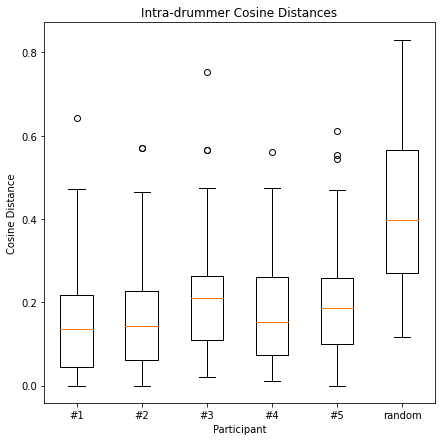

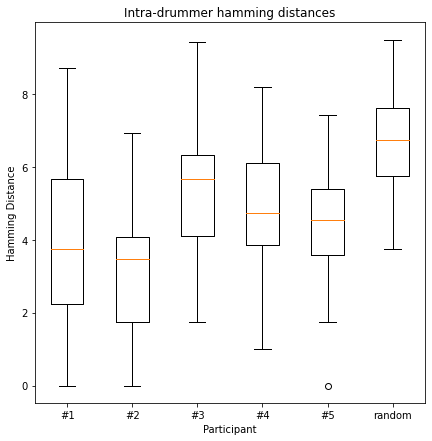

In [ ]:
drummers = ["genis", "ignasi", "morgan", "pau", "luis", "random"]
participants = ['#1','#2','#3','#4','#5','random']
# Plot intra-distances for cosine
cosine_distances_compiled['random'] = random_cosine_distances
data = [cosine_distances_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Intra-drummer Cosine Distances')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Cosine Distance')
plt.show()

# Plot intra-distances for hamming
hamming_distances_compiled['random'] = random_hamming_distances
data = [hamming_distances_compiled[drummer] for drummer in drummers]
fig2, ax2 = plt.subplots(figsize=(7,7))
ax2.set_title('Intra-drummer hamming distances')
ax2
ax2.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Hamming Distance')
plt.show()


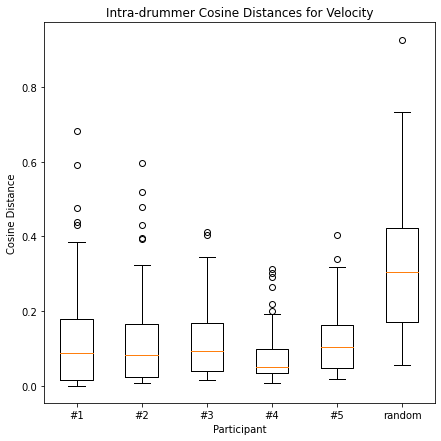

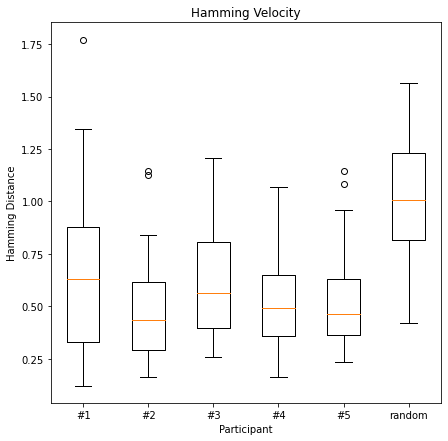

In [ ]:
drummers = ["genis", "ignasi", "morgan", "pau", "luis", "random"]
participants = ['#1','#2','#3','#4','#5','random']
# Plot intra-distances for cosine
cosine_distances_compiled_vels['random'] = random_cosine_distances_vels
data = [cosine_distances_compiled_vels[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Intra-drummer Cosine Distances for Velocity')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Cosine Distance')
plt.show()

# Plot intra-distances for hamming
hamming_distances_compiled_vels['random'] = random_hamming_distances_vels
data = [hamming_distances_compiled_vels[drummer] for drummer in drummers]
fig2, ax2 = plt.subplots(figsize=(7,7))
ax2.set_title('Hamming Velocity')
ax2
ax2.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Hamming Distance')
plt.show()


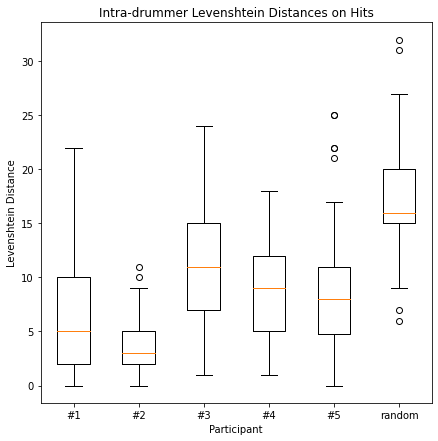

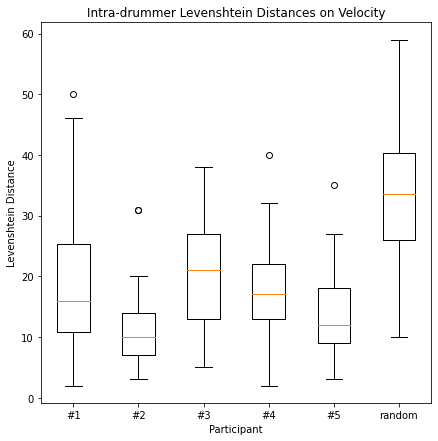

In [ ]:
drummers = ["genis", "ignasi", "morgan", "pau", "luis", "random"]
participants = ['#1','#2','#3','#4','#5','random']
# Plot intra-distances for cosine
levenshtein_distances_hits_compiled['random'] = random_levenshtein_distances_hits
data = [levenshtein_distances_hits_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Intra-drummer Levenshtein Distances on Hits')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Levenshtein Distance')
plt.show()

# Plot intra-distances for hamming
levenshtein_distances_vels_compiled['random'] = random_levenshtein_distances_vels
data = [levenshtein_distances_vels_compiled[drummer] for drummer in drummers]
fig2, ax2 = plt.subplots(figsize=(7,7))
ax2.set_title('Intra-drummer Levenshtein Distances on Velocity')
ax2
ax2.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Levenshtein Distance')
plt.show()

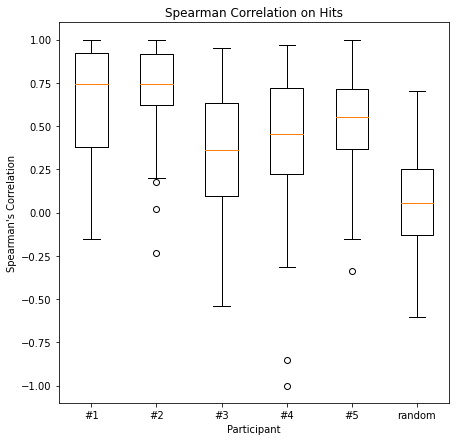

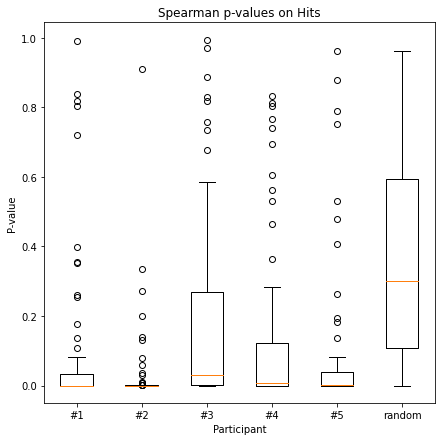

In [ ]:
import math
import numpy as np

drummers = ["genis", "ignasi", "morgan", "pau", "luis", "random"]
participants = ['#1','#2','#3','#4','#5','random']
# Plot intra-distances for cosine
spearmanr_corr_hits_compiled['random'] = random_spearmanr_corr_hits
spearmanr_corr_hits_compiled['luis'] = [x for x in spearmanr_corr_hits_compiled['luis'] if str(x) != 'nan']
data = [spearmanr_corr_hits_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Spearman Correlation on Hits')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Spearman\'s Correlation')
plt.show()


# Plot intra-distances for cosine
spearmanr_p_hits_compiled['random'] = random_spearmanr_p_hits
spearmanr_p_hits_compiled['luis'] = [x for x in spearmanr_p_hits_compiled['luis'] if str(x) != 'nan']
data = [spearmanr_p_hits_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Spearman p-values on Hits')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('P-value')
plt.show()

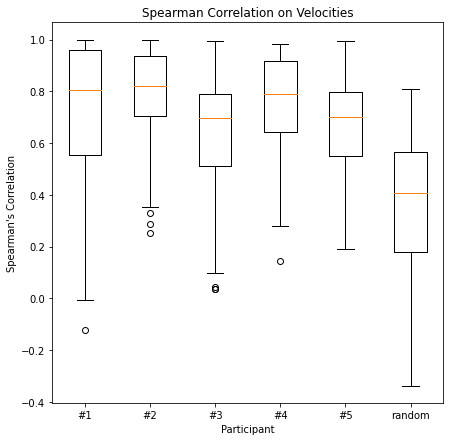

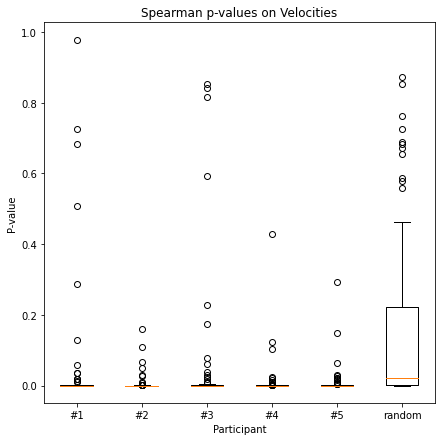

In [ ]:
drummers = ["genis", "ignasi", "morgan", "pau", "luis", "random"]
participants = ['#1','#2','#3','#4','#5','random']
# Plot intra-distances for cosine
spearmanr_corr_vels_compiled['random'] = random_spearmanr_corr_vels
spearmanr_corr_vels_compiled['luis'] = [x for x in spearmanr_corr_vels_compiled['luis'] if str(x) != 'nan']
data = [spearmanr_corr_vels_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Spearman Correlation on Velocities')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Spearman\'s Correlation')
plt.show()


# Plot intra-distances for cosine
spearmanr_p_vels_compiled['random'] = random_spearmanr_p_vels
spearmanr_p_vels_compiled['luis'] = [x for x in spearmanr_p_vels_compiled['luis'] if str(x) != 'nan']
data = [spearmanr_p_vels_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Spearman p-values on Velocities')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('P-value')
plt.show()

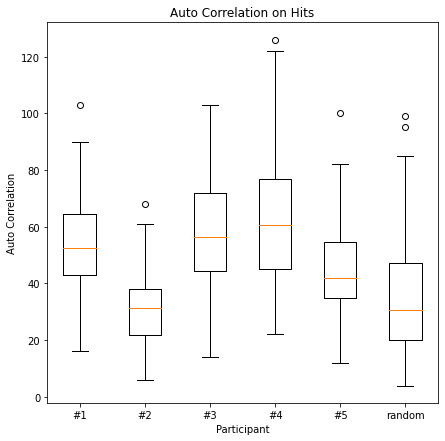

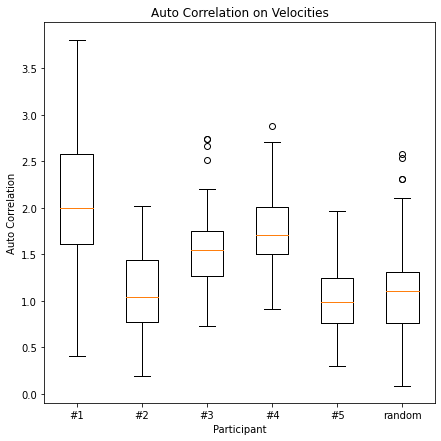

In [ ]:
drummers = ["genis", "ignasi", "morgan", "pau", "luis", "random"]
participants = ['#1','#2','#3','#4','#5','random']
# Plot intra-distances for cosine
autocorr_hits_compiled['random'] = random_autocorr_hits
autocorr_hits_compiled['luis'] = [x for x in autocorr_hits_compiled['luis'] if str(x) != 'nan']
data = [autocorr_hits_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Auto Correlation on Hits')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Auto Correlation')
plt.show()


# Plot intra-distances for cosine
autocorr_vels_compiled['random'] = random_autocorr_vels
autocorr_vels_compiled['luis'] = [x for x in autocorr_vels_compiled['luis'] if str(x) != 'nan']
data = [autocorr_vels_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Auto Correlation on Velocities')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Auto Correlation')
plt.show()

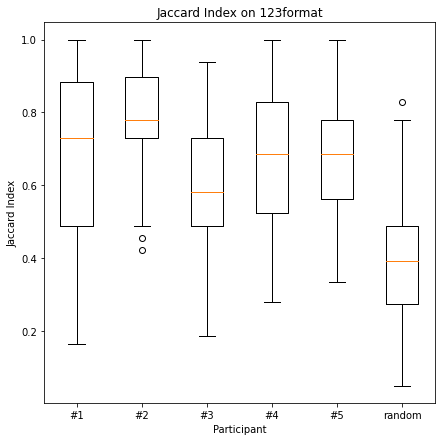

In [ ]:
# Plot intra-distances for Jaccard
jaccard_compiled['random'] = random_jaccard
jaccard_compiled['luis'] = [x for x in jaccard_compiled['luis'] if str(x) != 'nan']
data = [jaccard_compiled[drummer] for drummer in drummers]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Jaccard Index on 123format')
ax1
ax1.boxplot(data)
plt.xticks([1,2,3,4,5,6],participants)
plt.xlabel('Participant')
plt.ylabel('Jaccard Index')
plt.show()

Generating pd dataframe for Mr.  genis
Generating pd dataframe for Mr.  ignasi
Generating pd dataframe for Mr.  morgan
Generating pd dataframe for Mr.  pau
Generating pd dataframe for Mr.  luis
Generating pd dataframe for Mr.  random


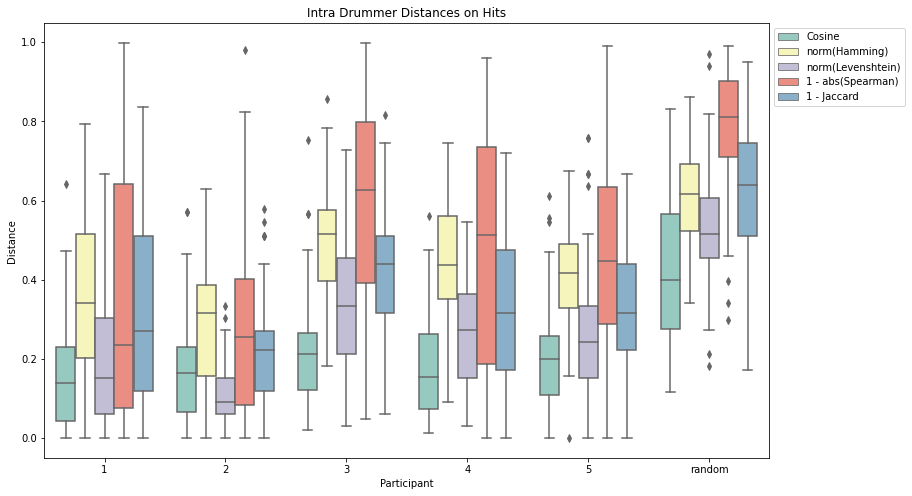

In [ ]:
import pandas as pd
import seaborn as sns
# drummer_name = 'genis'
# df_genis_hits = pd.DataFrame({'Cosine':cosine_distances_compiled[drummer_name],
#                 'Hamming':[num / 9 for num in hamming_distances_compiled[drummer_name]],
#                 'Levenshtein':[num / 35 for num in levenshtein_distances_hits_compiled[drummer_name]],
#                 'Spearman':[1 - abs(num) for num in spearmanr_corr_hits_compiled[drummer_name]],
#                 'p-value':spearmanr_p_hits_compiled[drummer_name],
#                 'Jaccard':[1 - num for num in jaccard_compiled[drummer_name]]})
# df_genis_hits

def generate_pd_for_drummers_hits(drummer_name):
  print('Generating pd dataframe for Mr. ',drummer_name)
  df_new = pd.DataFrame({'Cosine':cosine_distances_compiled[drummer_name][:69],
                'norm(Hamming)':[num / 11 for num in hamming_distances_compiled[drummer_name]][:69],
                'norm(Levenshtein)':[num / 33 for num in levenshtein_distances_hits_compiled[drummer_name]][:69],
                '1 - abs(Spearman)':[1 - abs(num) for num in spearmanr_corr_hits_compiled[drummer_name]][:69],
                'p-value':spearmanr_p_hits_compiled[drummer_name][:69],
                '1 - Jaccard':[1 - num for num in jaccard_compiled[drummer_name]][:69]})
  return df_new

df_list = []
i = 0
for drummer in drummers:
  i = i + 1
  if i == 6:
    df_list.append(generate_pd_for_drummers_hits(drummer).assign(Participant='random'))
  else:
    df_list.append(generate_pd_for_drummers_hits(drummer).assign(Participant=str(i)))

cdf = pd.concat(df_list).drop(columns=['p-value'])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Participant'], var_name=['Metric'])      # MELT

plt.figure(figsize=(13,8))
ax = sns.boxplot(x="Participant", y="value", hue="Metric", data=mdf, palette="Set3")  # RUN PLOT   
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Distance')
plt.title('Intra Drummer Distances on Hits')
plt.show()

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Participant']]
p_df[p_df['Participant'] == '1'].mean()

p-value        9.680175e-02
Participant    1.610306e+66
dtype: float64

Generating pd dataframe for Mr.  genis
Generating pd dataframe for Mr.  ignasi
Generating pd dataframe for Mr.  morgan
Generating pd dataframe for Mr.  pau
Generating pd dataframe for Mr.  luis
Generating pd dataframe for Mr.  random


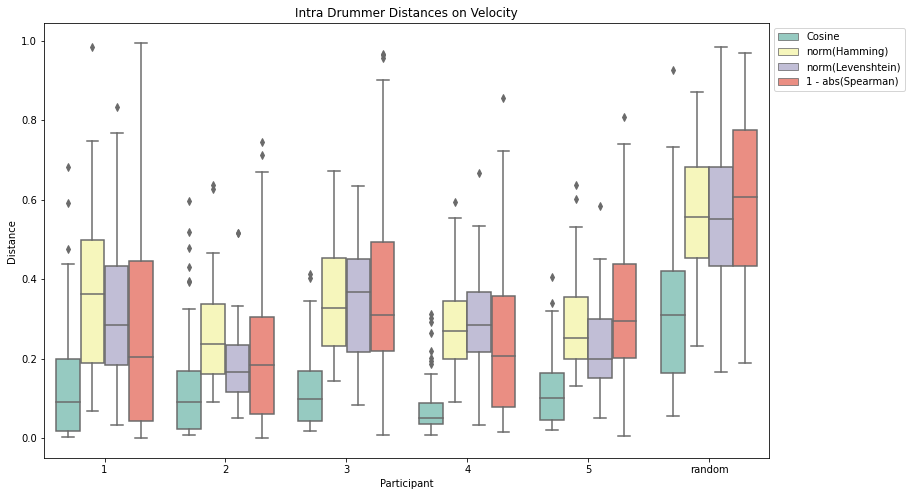

In [ ]:
def generate_pd_for_drummers_vels(drummer_name):
  print('Generating pd dataframe for Mr. ',drummer_name)
  df_new = pd.DataFrame({'Cosine':cosine_distances_compiled_vels[drummer_name][:69],
                'norm(Hamming)':[num / 1.8 for num in hamming_distances_compiled_vels[drummer_name]][:69],
                'norm(Levenshtein)':[num / 60 for num in levenshtein_distances_vels_compiled[drummer_name]][:69],
                '1 - abs(Spearman)':[1 - abs(num) for num in spearmanr_corr_vels_compiled[drummer_name]][:69],
                'p-value':spearmanr_p_vels_compiled[drummer_name][:69]})
  return df_new

df_list = []
i = 0
for drummer in drummers:
  i = i + 1
  if i == 6:
    df_list.append(generate_pd_for_drummers_vels(drummer).assign(Participant='random'))
  else:
    df_list.append(generate_pd_for_drummers_vels(drummer).assign(Participant=str(i)))

cdf = pd.concat(df_list).drop(columns=['p-value'])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Participant'], var_name=['Metric'])      # MELT

plt.figure(figsize=(13,8))
ax = sns.boxplot(x="Participant", y="value", hue="Metric", data=mdf, palette="Set3")  # RUN PLOT 
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Distance')
plt.title('Intra Drummer Distances on Velocity')
plt.show()

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Participant']]
p_df[p_df['Participant'] == 'random'].mean()

p-value    0.169809
dtype: float64

## Inter-drummer calculations

In [ ]:
########################################
########################################
# Inter DRUMMER CALCULATIONS
########################################
########################################
random_cosine_distances, random_hamming_distances, random_levenshtein_distances_hits, random_levenshtein_distances_vels,\
  random_spearmanr_corr_hits, random_spearmanr_corr_vels, random_spearmanr_p_hits, random_spearmanr_p_vels,\
  random_autocorr_hits, random_autocorr_vels, random_jaccard, random_cosine_distances_vels, random_hamming_distances_vels = get_randomised_distances(105)

drummers = ["genis", 'ignasi', "morgan", "pau", "luis"]

inter_cosine_distances = {x: [] for x in unique_files_tested_from_gmd}
inter_hamming_distances = {x: [] for x in unique_files_tested_from_gmd}
inter_cosine_distances_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_hamming_distances_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_levenshtein_distances_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_levenshtein_distances_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_corr_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_corr_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_p_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_p_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_autocorr_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_autocorr_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_jaccard = {x: [] for x in unique_files_tested_from_gmd}

compiled_123_formats_per_track = {}
compiled_velocity_grooves_per_track = {}

for track in unique_files_tested_from_gmd:
    compiled_123_formats = []
    compiled_velocity_grooves = []
    for drummer in drummers:
        compiled_123_formats.extend(squeezed_123format_data[track][drummer])
        compiled_velocity_grooves.extend(squeezed_velocity_groove_data[track][drummer])

    cosine_distances_inter = []
    hamming_distances_inter = []
    cosine_distances_inter_vels = []
    hamming_distances_inter_vels = []
    levenshtein_distances_hits_inter = []
    levenshtein_distances_vels_inter = []
    spearmanr_corr_hits_inter = []
    spearmanr_corr_vels_inter = []
    spearmanr_p_hits_inter = []
    spearmanr_p_vels_inter = []
    autocorr_hits_inter = []
    autocorr_vels_inter = []
    jaccard_inter = []

    # calculate cosine distances
    for idx0 in range(len(compiled_123_formats)):
        for idx1 in range(idx0 + 1, len(compiled_123_formats)):
            cosine_distances_inter.append(cosine_distance(compiled_123_formats[idx0], compiled_123_formats[idx1]))
            hamming_distances_inter.append(
                hamming_distance(compiled_123_formats[idx0], compiled_123_formats[idx1]))
            cosine_distances_inter_vels.append(cosine_distance(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1]))
            hamming_distances_inter_vels.append(
                hamming_distance(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1]))
            
            lvdv, lvdh = levenshtein_distance(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1],\
                                              compiled_123_formats[idx0], compiled_123_formats[idx1])
            levenshtein_distances_hits_inter.append(lvdh)
            levenshtein_distances_vels_inter.append(lvdv)

            spearmanr_corr_hits_inter.append(stats.spearmanr(compiled_123_formats[idx0], compiled_123_formats[idx1])[0])
            spearmanr_corr_vels_inter.append(stats.spearmanr(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1])[0])
            spearmanr_p_hits_inter.append(stats.spearmanr(compiled_123_formats[idx0], compiled_123_formats[idx1])[1])
            spearmanr_p_vels_inter.append(stats.spearmanr(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1])[1])

            autocorr_hits_inter.append(np.correlate(compiled_123_formats[idx0], compiled_123_formats[idx1]).sum())
            autocorr_vels_inter.append(np.correlate(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1]).sum())
            jaccard_inter.append(jaccard_index_of_2_123format_data(compiled_123_formats[idx0], compiled_123_formats[idx1]))


    inter_cosine_distances[track] = cosine_distances_inter
    inter_hamming_distances[track] = hamming_distances_inter
    inter_cosine_distances_vels[track] = cosine_distances_inter_vels
    inter_hamming_distances_vels[track] = hamming_distances_inter_vels
    inter_levenshtein_distances_hits[track] = levenshtein_distances_hits_inter
    inter_levenshtein_distances_vels[track] = levenshtein_distances_vels_inter

    inter_spearmanr_corr_hits[track] = spearmanr_corr_hits_inter
    inter_spearmanr_corr_vels[track] = spearmanr_corr_vels_inter
    inter_spearmanr_p_hits[track] = spearmanr_p_hits_inter
    inter_spearmanr_p_vels[track] = spearmanr_p_vels_inter

    inter_autocorr_hits[track] = autocorr_hits_inter
    inter_autocorr_vels[track] = autocorr_vels_inter
    inter_jaccard[track] = jaccard_inter

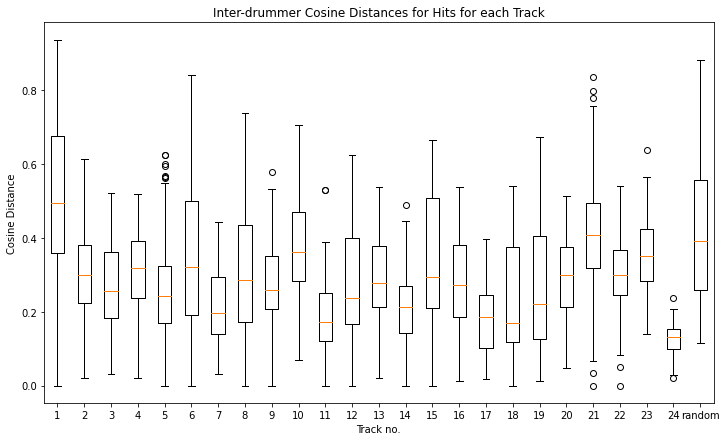

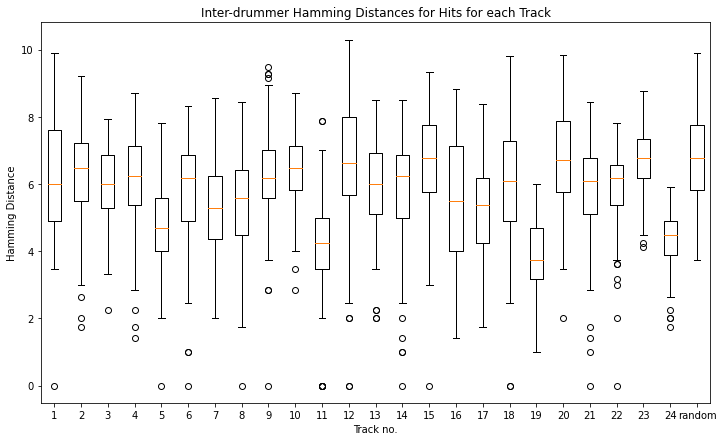

In [ ]:
#drummers = ["genis",'ignasi', "morgan", "pau", "luis", "random"]

index = np.arange(25)+1

# Plot inter-distances for cosine
data = [inter_cosine_distances[track] for track in unique_files_tested_from_gmd]
data.append(random_cosine_distances)
fig3, ax3 = plt.subplots(figsize=(12,7))
ax3.set_title('Inter-drummer Cosine Distances for Hits for each Track')
ax3
ax3.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Cosine Distance')
plt.show()


# Plot inter-distances for hamming
data = [inter_hamming_distances[track] for track in unique_files_tested_from_gmd]
data.append(random_hamming_distances)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Hamming Distances for Hits for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Hamming Distance')
plt.show()

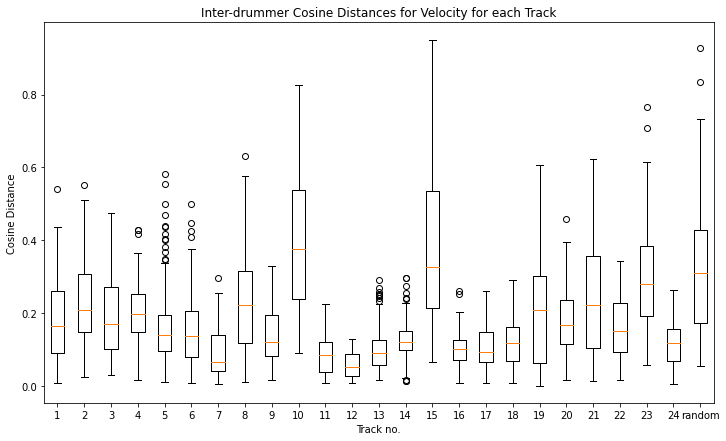

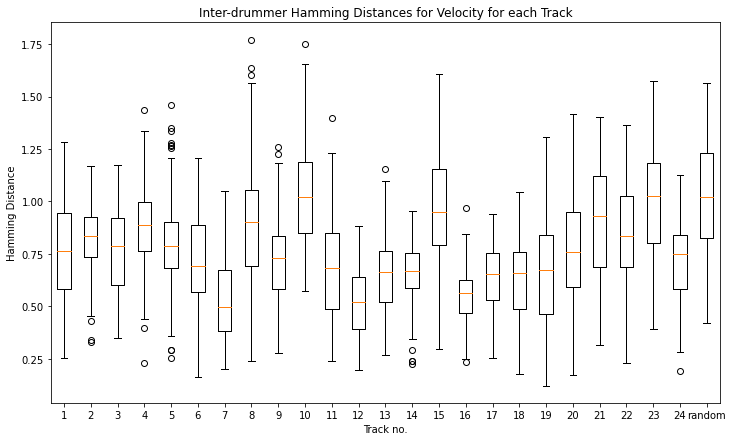

In [ ]:
#drummers = ["genis",'ignasi', "morgan", "pau", "luis", "random"]

index = np.arange(25)+1

# Plot inter-distances for cosine
data = [inter_cosine_distances_vels[track] for track in unique_files_tested_from_gmd]
data.append(random_cosine_distances_vels)
fig3, ax3 = plt.subplots(figsize=(12,7))
ax3.set_title('Inter-drummer Cosine Distances for Velocity for each Track')
ax3
ax3.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Cosine Distance')
plt.show()


# Plot inter-distances for hamming
data = [inter_hamming_distances_vels[track] for track in unique_files_tested_from_gmd]
data.append(random_hamming_distances_vels)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Hamming Distances for Velocity for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Hamming Distance')
plt.show()

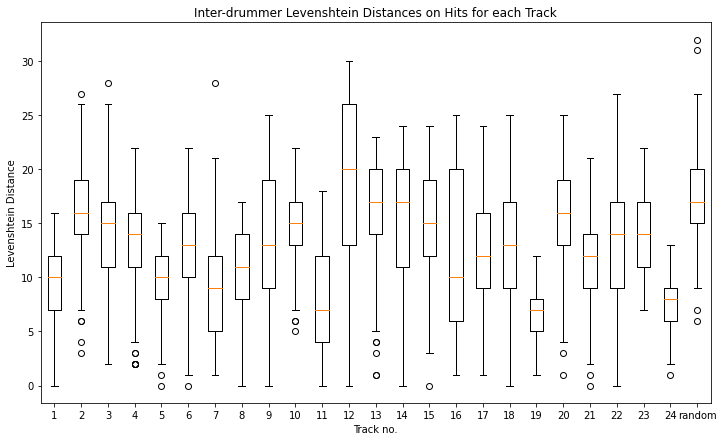

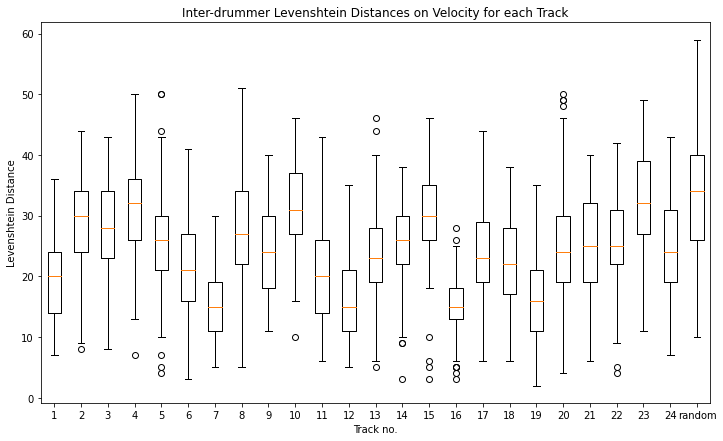

In [ ]:
# Plot inter-distances for hamming
data = [inter_levenshtein_distances_hits[track] for track in unique_files_tested_from_gmd]
data.append(random_levenshtein_distances_hits)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Levenshtein Distances on Hits for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Levenshtein Distance')
plt.show()

# Plot inter-distances for hamming
data = [inter_levenshtein_distances_vels[track] for track in unique_files_tested_from_gmd]
data.append(random_levenshtein_distances_vels)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Levenshtein Distances on Velocity for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Levenshtein Distance')
plt.show()

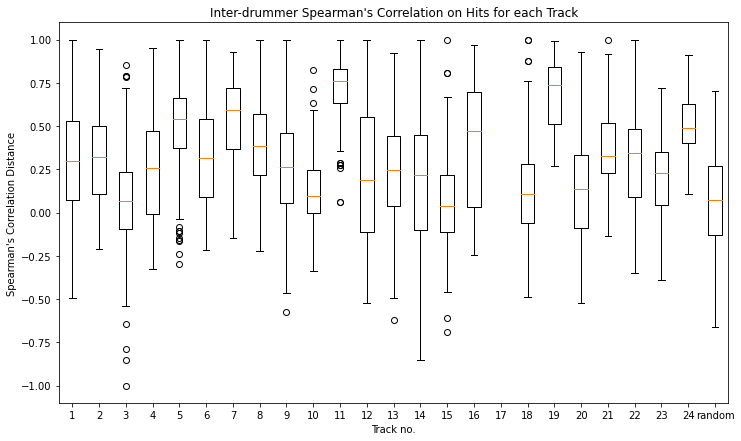

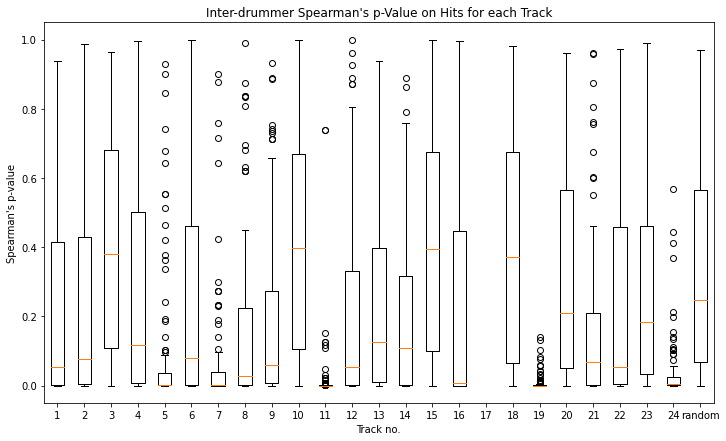

In [ ]:
# Plot inter-distances for Spearman's Correlation for hits
data = [inter_spearmanr_corr_hits[track] for track in unique_files_tested_from_gmd]
data.append(random_spearmanr_corr_hits)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Spearman\'s Correlation on Hits for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Spearman\'s Correlation Distance')
plt.show()

# Plot inter-distances for Spearman's p-value for hits
data = [inter_spearmanr_p_hits[track] for track in unique_files_tested_from_gmd]
data.append(random_spearmanr_p_hits)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Spearman\'s p-Value on Hits for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Spearman\'s p-value')
plt.show()

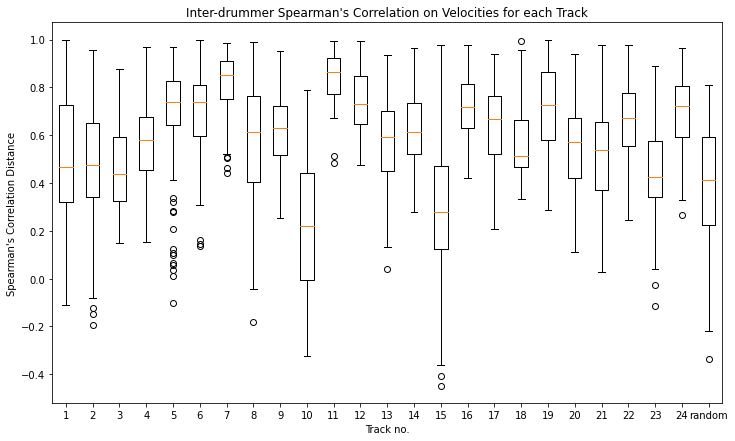

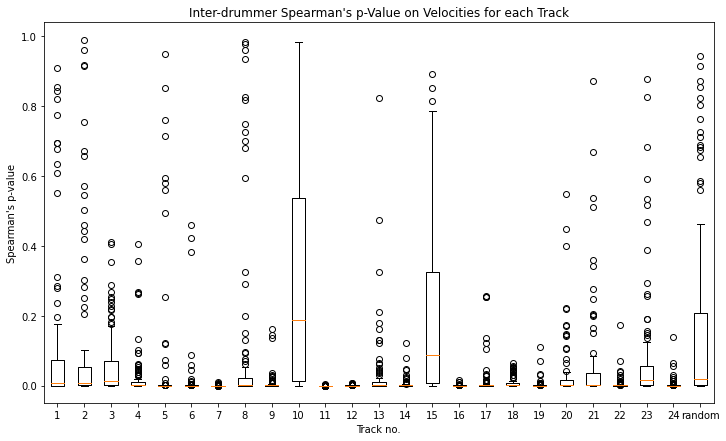

In [ ]:
# Plot inter-distances for Spearman's Correlation for vels
data = [inter_spearmanr_corr_vels[track] for track in unique_files_tested_from_gmd]
data.append(random_spearmanr_corr_vels)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Spearman\'s Correlation on Velocities for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Spearman\'s Correlation Distance')
plt.show()

# Plot inter-distances for Spearman's p-value for vels
data = [inter_spearmanr_p_vels[track] for track in unique_files_tested_from_gmd]
data.append(random_spearmanr_p_vels)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Spearman\'s p-Value on Velocities for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Spearman\'s p-value')
plt.show()

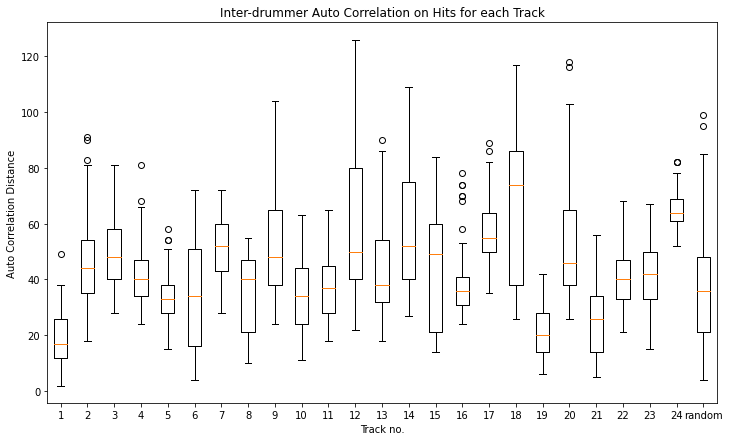

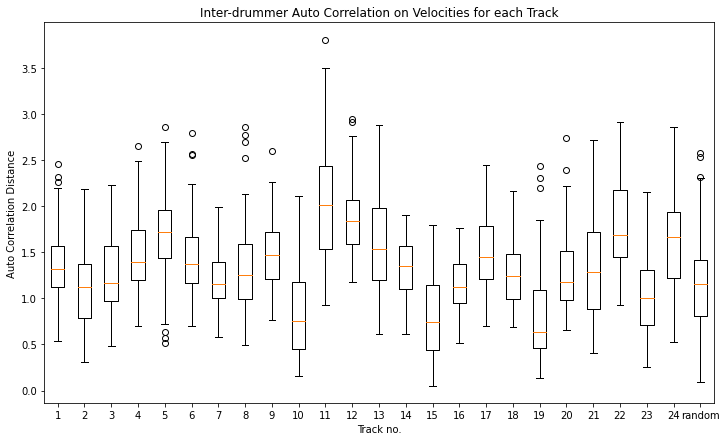

In [ ]:
# Plot inter-distances for Spearman's Correlation for vels
data = [inter_autocorr_hits[track] for track in unique_files_tested_from_gmd]
data.append(random_autocorr_hits)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Auto Correlation on Hits for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Auto Correlation Distance')
plt.show()

# Plot inter-distances for Spearman's Correlation for vels
data = [inter_autocorr_vels[track] for track in unique_files_tested_from_gmd]
data.append(random_autocorr_vels)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Auto Correlation on Velocities for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Auto Correlation Distance')
plt.show()

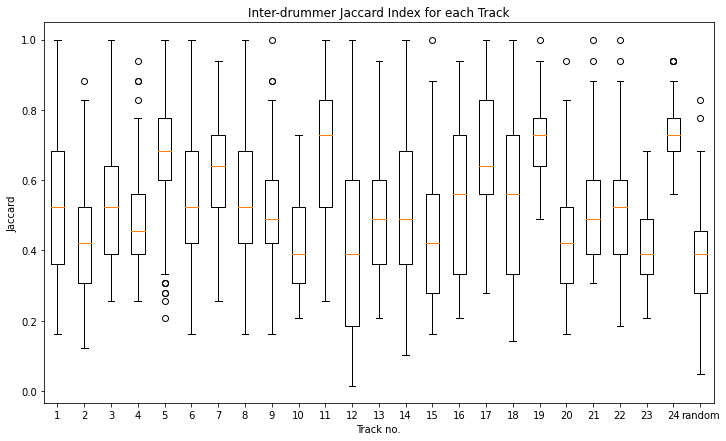

In [ ]:
# Plot inter-distances for Spearman's Correlation for vels
data = [inter_jaccard[track] for track in unique_files_tested_from_gmd]
data.append(random_jaccard)
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Inter-drummer Jaccard Index for each Track')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])
plt.xlabel('Track no.')
plt.ylabel('Jaccard')
plt.show()

In [ ]:
def generate_pd_for_tracks_hits(track):
  print('Generating pd dataframe for track ',track)
  df_new = pd.DataFrame({'Cosine':inter_cosine_distances[track],
                'norm(Hamming)':[num / 11 for num in inter_hamming_distances[track]],
                'norm(Levenshtein)':[num / 33 for num in inter_levenshtein_distances_hits[track]],
                '1 - abs(Spearman)':[1 - abs(num) for num in inter_spearmanr_corr_hits[track]],
                'p-value':inter_spearmanr_p_hits[track],
                'Jaccard':[1 - num for num in inter_jaccard[track]]})
  return df_new

df_list = []
i = 0
for track in unique_files_tested_from_gmd:
  i = i + 1
  df_list.append(generate_pd_for_tracks_hits(track).assign(Track=str(i)))

df_random = pd.DataFrame({'Cosine':random_cosine_distances,
              'norm(Hamming)':[num / 11 for num in random_hamming_distances],
              'norm(Levenshtein)':[num / 33 for num in random_levenshtein_distances_hits],
              '1 - abs(Spearman)':[1 - abs(num) for num in random_spearmanr_corr_hits],
              'p-value':random_spearmanr_p_vels,
              'Jaccard':random_jaccard})

df_list.append(df_random.assign(Track='random'))



cdf = pd.concat(df_list).drop(columns=['p-value'])                               # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Track'], var_name=['Metric'])      # MELT

plt.figure(figsize=(20,8))
ax = sns.boxplot(x="Track", y="value", hue="Metric", data=mdf, palette="Set3")  # RUN PLOT   
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Distance')
plt.title('Inter Drummer Distances on Hits')
plt.show()

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Track']]

HwI = []
for i in range(1,25):
  HwI.append(p_df[p_df['Track'] == str(i)].mean()['p-value'])


HwI.append(p_df[p_df['Track'] == 'random'].mean()['p-value'])

In [ ]:
def generate_pd_for_tracks_vels(track):
  print('Generating pd dataframe for track ',track)
  df_new = pd.DataFrame({'Cosine':inter_cosine_distances_vels[track],
                'norm(Hamming)':[num / 1.8 for num in inter_hamming_distances_vels[track]],
                'norm(Levenshtein)':[num / 60 for num in inter_levenshtein_distances_vels[track]],
                '1 - abs(Spearman)':[1 - abs(num) for num in inter_spearmanr_corr_vels[track]],
                'p-value':inter_spearmanr_p_vels[track]})
  return df_new

df_list = []
i = 0
for track in unique_files_tested_from_gmd:
  i = i + 1
  df_list.append(generate_pd_for_tracks_vels(track).assign(Track=str(i)))

df_random = pd.DataFrame({'Cosine':random_cosine_distances_vels,
              'norm(Hamming)':[num / 1.8 for num in random_hamming_distances_vels],
              'norm(Levenshtein)':[num / 60 for num in random_levenshtein_distances_vels],
              '1 - abs(Spearman)':[1 - abs(num) for num in random_spearmanr_corr_vels],
              'p-value':random_spearmanr_p_vels})

df_list.append(df_random.assign(Track='random'))



cdf = pd.concat(df_list).drop(columns=['p-value'])                               # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Track'], var_name=['Metric'])      # MELT

plt.figure(figsize=(20,8))
ax = sns.boxplot(x="Track", y="value", hue="Metric", data=mdf, palette="Set3")  # RUN PLOT   
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Distance')
plt.title('Inter Drummer Distances on Velocity')
plt.show()

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Track']]

VwI = []

for i in range(1,25):
  VwI.append(p_df[p_df['Track'] == str(i)].mean()['p-value'])


VwI.append(p_df[p_df['Track'] == 'random'].mean()['p-value'])

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Track']]

for i in range(1,25):
  print('\n\nTrack no. ',i,' with mean:')
  print(p_df[p_df['Track'] == str(i)].mean()['p-value'])

print('\n\nRandom with mean:')
print(p_df[p_df['Track'] == 'random'].mean())

## Inter-drummer calculations WITHOUT PARTICIPANT \#2
Below will be everything repeated without participant \#2's data.

In [ ]:
########################################
########################################
# Inter DRUMMER CALCULATIONS
########################################
########################################
random_cosine_distances, random_hamming_distances, random_levenshtein_distances_hits, random_levenshtein_distances_vels,\
  random_spearmanr_corr_hits, random_spearmanr_corr_vels, random_spearmanr_p_hits, random_spearmanr_p_vels,\
  random_autocorr_hits, random_autocorr_vels, random_jaccard, random_cosine_distances_vels, random_hamming_distances_vels = get_randomised_distances(105)

drummers = ["genis", "morgan", "pau", "luis"]

inter_cosine_distances = {x: [] for x in unique_files_tested_from_gmd}
inter_hamming_distances = {x: [] for x in unique_files_tested_from_gmd}
inter_cosine_distances_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_hamming_distances_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_levenshtein_distances_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_levenshtein_distances_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_corr_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_corr_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_p_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_spearmanr_p_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_autocorr_hits = {x: [] for x in unique_files_tested_from_gmd}
inter_autocorr_vels = {x: [] for x in unique_files_tested_from_gmd}
inter_jaccard = {x: [] for x in unique_files_tested_from_gmd}

compiled_123_formats_per_track = {}
compiled_velocity_grooves_per_track = {}

for track in unique_files_tested_from_gmd:
    compiled_123_formats = []
    compiled_velocity_grooves = []
    for drummer in drummers:
        compiled_123_formats.extend(squeezed_123format_data[track][drummer])
        compiled_velocity_grooves.extend(squeezed_velocity_groove_data[track][drummer])

    cosine_distances_inter = []
    hamming_distances_inter = []
    cosine_distances_inter_vels = []
    hamming_distances_inter_vels = []
    levenshtein_distances_hits_inter = []
    levenshtein_distances_vels_inter = []
    spearmanr_corr_hits_inter = []
    spearmanr_corr_vels_inter = []
    spearmanr_p_hits_inter = []
    spearmanr_p_vels_inter = []
    autocorr_hits_inter = []
    autocorr_vels_inter = []
    jaccard_inter = []

    # calculate cosine distances
    for idx0 in range(len(compiled_123_formats)):
        for idx1 in range(idx0 + 1, len(compiled_123_formats)):
            cosine_distances_inter.append(cosine_distance(compiled_123_formats[idx0], compiled_123_formats[idx1]))
            hamming_distances_inter.append(
                hamming_distance(compiled_123_formats[idx0], compiled_123_formats[idx1]))
            cosine_distances_inter_vels.append(cosine_distance(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1]))
            hamming_distances_inter_vels.append(
                hamming_distance(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1]))
            
            lvdv, lvdh = levenshtein_distance(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1],\
                                              compiled_123_formats[idx0], compiled_123_formats[idx1])
            levenshtein_distances_hits_inter.append(lvdh)
            levenshtein_distances_vels_inter.append(lvdv)

            spearmanr_corr_hits_inter.append(stats.spearmanr(compiled_123_formats[idx0], compiled_123_formats[idx1])[0])
            spearmanr_corr_vels_inter.append(stats.spearmanr(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1])[0])
            spearmanr_p_hits_inter.append(stats.spearmanr(compiled_123_formats[idx0], compiled_123_formats[idx1])[1])
            spearmanr_p_vels_inter.append(stats.spearmanr(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1])[1])

            autocorr_hits_inter.append(np.correlate(compiled_123_formats[idx0], compiled_123_formats[idx1]).sum())
            autocorr_vels_inter.append(np.correlate(compiled_velocity_grooves[idx0], compiled_velocity_grooves[idx1]).sum())
            jaccard_inter.append(jaccard_index_of_2_123format_data(compiled_123_formats[idx0], compiled_123_formats[idx1]))


    inter_cosine_distances[track] = cosine_distances_inter
    inter_hamming_distances[track] = hamming_distances_inter
    inter_cosine_distances_vels[track] = cosine_distances_inter_vels
    inter_hamming_distances_vels[track] = hamming_distances_inter_vels
    inter_levenshtein_distances_hits[track] = levenshtein_distances_hits_inter
    inter_levenshtein_distances_vels[track] = levenshtein_distances_vels_inter

    inter_spearmanr_corr_hits[track] = spearmanr_corr_hits_inter
    inter_spearmanr_corr_vels[track] = spearmanr_corr_vels_inter
    inter_spearmanr_p_hits[track] = spearmanr_p_hits_inter
    inter_spearmanr_p_vels[track] = spearmanr_p_vels_inter

    inter_autocorr_hits[track] = autocorr_hits_inter
    inter_autocorr_vels[track] = autocorr_vels_inter
    inter_jaccard[track] = jaccard_inter

In [ ]:
def generate_pd_for_tracks_hits(track):
  print('Generating pd dataframe for track ',track)
  df_new = pd.DataFrame({'Cosine':inter_cosine_distances[track],
                'norm(Hamming)':[num / 11 for num in inter_hamming_distances[track]],
                'norm(Levenshtein)':[num / 33 for num in inter_levenshtein_distances_hits[track]],
                '1 - abs(Spearman)':[1 - abs(num) for num in inter_spearmanr_corr_hits[track]],
                'p-value':inter_spearmanr_p_hits[track],
                'Jaccard':[1 - num for num in inter_jaccard[track]]})
  return df_new

df_list = []
i = 0
for track in unique_files_tested_from_gmd:
  i = i + 1
  df_list.append(generate_pd_for_tracks_hits(track).assign(Track=str(i)))

df_random = pd.DataFrame({'Cosine':random_cosine_distances[:66],
              'norm(Hamming)':[num / 11 for num in random_hamming_distances][:66],
              'norm(Levenshtein)':[num / 33 for num in random_levenshtein_distances_hits][:66],
              '1 - abs(Spearman)':[1 - abs(num) for num in random_spearmanr_corr_hits][:66],
              'p-value':random_spearmanr_p_vels[:66],
              'Jaccard':random_jaccard[:66]})

df_list.append(df_random.assign(Track='random'))



cdf = pd.concat(df_list).drop(columns=['p-value'])                               # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Track'], var_name=['Metric'])      # MELT

plt.figure(figsize=(20,8))
ax = sns.boxplot(x="Track", y="value", hue="Metric", data=mdf, palette="Set3")  # RUN PLOT   
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Distance')
plt.title('Inter Drummer Distances on Hits WITHOUT the 2nd Participant')
plt.show()

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Track']]

HnoI = []

for i in range(1,25):
  HnoI.append(p_df[p_df['Track'] == str(i)].mean()['p-value'])

HnoI.append(p_df[p_df['Track'] == 'random'].mean()['p-value'])

In [ ]:
def generate_pd_for_tracks_vels(track):
  print('Generating pd dataframe for track ',track)
  df_new = pd.DataFrame({'Cosine':inter_cosine_distances_vels[track],
                'norm(Hamming)':[num / 1.8 for num in inter_hamming_distances_vels[track]],
                'norm(Levenshtein)':[num / 60 for num in inter_levenshtein_distances_vels[track]],
                '1 - abs(Spearman)':[1 - abs(num) for num in inter_spearmanr_corr_vels[track]],
                'p-value':inter_spearmanr_p_vels[track]})
  return df_new

df_list = []
i = 0
for track in unique_files_tested_from_gmd:
  i = i + 1
  df_list.append(generate_pd_for_tracks_vels(track).assign(Track=str(i)))

df_random = pd.DataFrame({'Cosine':random_cosine_distances_vels[:66],
              'norm(Hamming)':[num / 1.8 for num in random_hamming_distances_vels][:66],
              'norm(Levenshtein)':[num / 60 for num in random_levenshtein_distances_vels][:66],
              '1 - abs(Spearman)':[1 - abs(num) for num in random_spearmanr_corr_vels][:66],
              'p-value':random_spearmanr_p_vels[:66]})

df_list.append(df_random.assign(Track='random'))



cdf = pd.concat(df_list).drop(columns=['p-value'])                               # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Track'], var_name=['Metric'])      # MELT

plt.figure(figsize=(20,8))
ax = sns.boxplot(x="Track", y="value", hue="Metric", data=mdf, palette="Set3")  # RUN PLOT   
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Distance')
plt.title('Inter Drummer Distances on Velocity')
plt.show()

In [ ]:
p_df = pd.concat(df_list)  
p_df = p_df[['p-value','Track']]

VnoI = []

for i in range(1,25):
  VnoI.append(p_df[p_df['Track'] == str(i)].mean()['p-value'])


VnoI.append(p_df[p_df['Track'] == 'random'].mean()['p-value'])

In [ ]:
# Numbers of pairs of bars you want
N = 25

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = HwI
# Specify the values of orange bars (height)
orange_bar = HnoI

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='p-value WITH #2')
plt.bar(ind + width, orange_bar, width, label='p-value WITHOUT #2')

plt.xlabel('Track')
plt.ylabel('p-value')
plt.title('Spearman\'s p-value comparison of hits with and without the 2nd participant')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [ ]:
# Numbers of pairs of bars you want
N = 25

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = VwI
# Specify the values of orange bars (height)
orange_bar = VnoI

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='p-value WITH #2')
plt.bar(ind + width, orange_bar, width, label='p-value WITHOUT #2')

plt.xlabel('Track')
plt.ylabel('p-value')
plt.title('Spearman\'s p-value comparison of velocity with and without the 2nd participant')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24','random'])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

# Heatmap for different Drummers
Here I first tried to do it automatically but it was buggy as hell.  Then I just compared them one by one, just 15 comparisons...

In [ ]:
drummers = ["genis", "ignasi", "morgan", "pau", "luis"]

gg = []
gi = []
gm = []
gp = []
gl = []

ii = []
im = []
ip = []
il = []

mm = []
mp = []
ml = []

pp = []
pl = []

ll = []

for track in unique_files_tested_from_gmd:
    for i in range(3):
        for j in range(3):
            gg.append(cosine_distance(squeezed_123format_data[track]['genis'][i], squeezed_123format_data[track]['genis'][j]))
            gi.append(cosine_distance(squeezed_123format_data[track]['genis'][i], squeezed_123format_data[track]['ignasi'][j]))
            gm.append(cosine_distance(squeezed_123format_data[track]['genis'][i], squeezed_123format_data[track]['morgan'][j]))
            gp.append(cosine_distance(squeezed_123format_data[track]['genis'][i], squeezed_123format_data[track]['pau'][j]))
            gl.append(cosine_distance(squeezed_123format_data[track]['genis'][i], squeezed_123format_data[track]['luis'][j]))

            ii.append(cosine_distance(squeezed_123format_data[track]['ignasi'][i], squeezed_123format_data[track]['ignasi'][j]))
            im.append(cosine_distance(squeezed_123format_data[track]['ignasi'][i], squeezed_123format_data[track]['morgan'][j]))
            ip.append(cosine_distance(squeezed_123format_data[track]['ignasi'][i], squeezed_123format_data[track]['pau'][j]))
            il.append(cosine_distance(squeezed_123format_data[track]['ignasi'][i], squeezed_123format_data[track]['luis'][j]))

            mm.append(cosine_distance(squeezed_123format_data[track]['morgan'][i], squeezed_123format_data[track]['morgan'][j]))
            mp.append(cosine_distance(squeezed_123format_data[track]['morgan'][i], squeezed_123format_data[track]['pau'][j]))
            ml.append(cosine_distance(squeezed_123format_data[track]['morgan'][i], squeezed_123format_data[track]['luis'][j]))

            pp.append(cosine_distance(squeezed_123format_data[track]['pau'][i], squeezed_123format_data[track]['pau'][j]))
            pl.append(cosine_distance(squeezed_123format_data[track]['pau'][i], squeezed_123format_data[track]['luis'][j]))

            ll.append(cosine_distance(squeezed_123format_data[track]['luis'][i], squeezed_123format_data[track]['luis'][j]))

def mean_list(lst):
  return sum(lst) / len(lst)

cosine_dist_corr_matrix = [[mean_list(gg),mean_list(gi),mean_list(gm),mean_list(gp),mean_list(gl)],\
                           [mean_list(gi),mean_list(ii),mean_list(im),mean_list(ip),mean_list(il)],\
                           [mean_list(gm),mean_list(im),mean_list(mm),mean_list(mp),mean_list(ml)],\
                           [mean_list(gp),mean_list(ip),mean_list(mp),mean_list(pp),mean_list(pl)],\
                           [mean_list(gl),mean_list(il),mean_list(ml),mean_list(pl),mean_list(ll)]
                           ]

In [ ]:
import seaborn as sns
import numpy as np

participants = ['#1','#2','#3','#4','#5']
mask = np.zeros_like(cosine_dist_corr_matrix)
mask[np.triu_indices_from(mask)] = np.array([0.,1.,1.,1.,1.,0.,1.,1.,1.,0.,1.,1.,0.,1.,0.])
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    
    ax = sns.heatmap(cosine_dist_corr_matrix, mask=mask, xticklabels=participants, yticklabels=participants,\
                     vmax=.3, square=True, annot=True, cmap="YlGnBu")
plt.xlabel('Participant')
plt.ylabel('Participant')
plt.title('Cosine Distance between Different Participants')
plt.show()

# Heat Map 

In [ ]:
from analysis.utils import midi_to_LeftRightHVO, midi_to_HVO, extract_style_from, get_dualization_heatmap_from_midis, get_inter_drummer_heatmaps
from GrooveEvaluator.feature_extractor import Feature_Extractor_From_HVO_SubSets
from GrooveEvaluator.plotting_utils import velocity_timing_heatmaps_scatter_plotter, global_features_plotter, separate_figues_by_tabs

from bokeh.io import output_file, show, save

import os, glob

import sys



In [ ]:
midi_folder = 'processed_data/InterDrummer_Repetitions/luis/' \
                'drummer1-eval_session-4_soul-groove4_80_beat_4-4_best_2bar_segment_6'

# Plotting Dualization
hvo_seq_dualized = midi_to_LeftRightHVO(os.path.join(midi_folder, "repetition_2.mid"))
# hvo_seq.hvo
hvo_seq_dualized.to_html_plot(show_figure=False)

# Plotting Original
hvo_seq_original = midi_to_HVO(os.path.join(midi_folder, "original.mid"))
# hvo_seq.hvo
hvo_seq_original.to_html_plot(show_figure=False)

############ QUICK GUIDE FOR LOADING DATA
# get drummers and filenames
data_folder = "processed_data/InterDrummer_Repetitions/luis"


## Plot the heatmaps
"""get_dualization_heatmap_from_midis(data_folder, save_path="heatmaps/LuisSessionAB_Separataed_BY_Style", separate_by_style=True)
get_dualization_heatmap_from_midis(data_folder, save_path="heatmaps/LuisSessionAB_ALL_STYLES_MIXED", separate_by_style=False)"""


get_inter_drummer_heatmaps("processed_data/InterDrummer_Repetitions/", ["genis", "ignasi", "luis", "morgan", "pau"],
                           save_path="heatmaps/InterDrummer_Separataed_BY_Style",
                           separate_by_style=True, mix_hands=False)
get_inter_drummer_heatmaps("processed_data/InterDrummer_Repetitions/", ["genis", "ignasi", "luis", "morgan", "pau"],
                           save_path="heatmaps/InterDrummer_ALL_STYLES_MIXED",
                           separate_by_style=False, mix_hands=False)

get_inter_drummer_heatmaps("processed_data/InterDrummer_Repetitions/", ["genis", "ignasi", "luis", "morgan", "pau"],
                           save_path="heatmaps/InterDrummer_LRMixed_Separataed_BY_Style",
                           separate_by_style=True, mix_hands=True)
get_inter_drummer_heatmaps("processed_data/InterDrummer_Repetitions/", ["genis", "ignasi",  "morgan", "pau", "luis"],
                           save_path="heatmaps/InterDrummer_LRMixed_ALL_STYLES_MIXED_CORRECT_ORDER",
                           separate_by_style=False, mix_hands=True)

# Instrument-Dualisation Comparison

Here is the Instrument-Dualisation Comparison.

## Loading the original MIDIs
As original MIDI files were neglected above, the original MIDI files shall be first loaded into the hvo structure first.

In [ ]:
ROLAND_REDUCED_MAPPING = {
    "KICK": [36],
    "SNARE": [38, 37, 40],
    "HH_CLOSED": [42, 22, 44],
    "HH_OPEN": [46, 26],
    "TOM_3_LO": [43, 58],
    "TOM_2_MID": [47, 45],
    "TOM_1_HI": [50, 48],
    "CRASH": [49, 52, 55, 57],
    "RIDE":  [51, 53, 59]
}

In [ ]:
 # get drummers and filenames
root_data_dir = "processed_data/InterDrummer_Repetitions"
drummers = ["genis", "ignasi", "morgan", "pau", "luis"]
original_fname = "original.mid"
repetition_fnames = ["repetition_0.mid", "repetition_1.mid", "repetition_2.mid"]

unique_files_tested_from_gmd = [x.split("/")[-1] for x in glob.glob(os.path.join(root_data_dir, drummers[0], "*"))]

# Load Data
hvo_seq_data = {x: {} for x in unique_files_tested_from_gmd}
ori_hvo_seq_data = {x: {} for x in unique_files_tested_from_gmd}
ori_hvo_hits_data = {x: {} for x in unique_files_tested_from_gmd}
hits_data = {x: {} for x in unique_files_tested_from_gmd}
squeezed_123format_data = {x: {} for x in unique_files_tested_from_gmd}
squeezed_velocity_groove_data = {x: {} for x in unique_files_tested_from_gmd}

# Load Data
for drummer in tqdm.tqdm(drummers):

    for unique_file_tested_from_gmd in unique_files_tested_from_gmd:

        
        hvo_seqs_repeated = []  # contains the hvo_sequence instances
        hits_repeated = []  # each entry has shape (32, 2)
        squeezed_123_repeated = []  # converted to 1, 2, 3 format
        squeezed_velocity_groove_repeated = []  # tappified left/right (only velocity)

        for repetition_fname in repetition_fnames:
            midi_filename = os.path.join(root_data_dir, drummer, unique_file_tested_from_gmd, repetition_fname)
            hvo_seq = midi_to_LeftRightHVO(midi_filename)
            hvo_seqs_repeated.append(hvo_seq.hvo)
            hits_repeated.append(hvo_seq.get("h"))
            squeezed_123_repeated.append(convert_hvo_sequence_to_123format(hvo_seq))
            velocities = hvo_seq.flatten_voices(voice_idx=0)[:, 2]
            if APPLY_METRICAL_STRUCTURE_TO_VELS == True:
              velocities = np.multiply(velocities,metrical_structure)
            squeezed_velocity_groove_repeated.append(velocities)

        hvo_seq_data[unique_file_tested_from_gmd][drummer] = hvo_seqs_repeated
        hits_data[unique_file_tested_from_gmd][drummer] = hits_repeated
        squeezed_123format_data[unique_file_tested_from_gmd][drummer] = squeezed_123_repeated
        squeezed_velocity_groove_data[unique_file_tested_from_gmd][drummer] = squeezed_velocity_groove_repeated
        if drummer == drummers[0]:
            midi_filename = os.path.join(root_data_dir, drummer, unique_file_tested_from_gmd, original_fname)
            original_hvo_seqs = midi_to_HVO(midi_filename, n_steps = 32)
            ori_hvo_seq_data[unique_file_tested_from_gmd] = original_hvo_seqs
            ori_hvo_hits_data[unique_file_tested_from_gmd] = original_hvo_seqs.hvo[:,:9]

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


## Instrument-Dualisation Comparison

In [ ]:
from sklearn.metrics import jaccard_score

def transform_123format_to_dualisation(_123format_data):
  R = []
  L = []
  for element in _123format_data:
    if element == 0.0:
      R.append(0.0)
      L.append(0.0)
    elif element == 1.0:
      R.append(0.0)
      L.append(1.0)
    elif element == 2.0:
      R.append(1.0)
      L.append(0.0)
    elif element == 3.0:
      R.append(1.0)
      L.append(1.0)
  return [R, L]

# # EXAMPLE 
# # Original 123format is 
# # [0.0, 0.0, 3.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 3.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0]
# # Result should be 
# # [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], 
# # [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
# print(transform_123format_to_dualisation(squeezed_123format_data['drummer8-session2-24_latin_84_beat_4-4_best_2bar_segment_32']['pau'][0]))


################################################################################


def voice_combination_dualisation_distance(voice_combination, dualisation, distance='cosine'):
  '''
  This function outputs the average distance of dualisation and the 2 instruments in the original file.
  distances can be chosen as: cosine, hamming, levenshtein, spearmanr, autocorr,  jaccard
  '''
  if distance == 'cosine':
    comp1_R = cosine_distance(np.array(voice_combination[0]), np.array(dualisation[0]))
    comp1_L = cosine_distance(np.array(voice_combination[1]), np.array(dualisation[1]))
    comp1 = (comp1_R + comp1_L) / 2

    comp2_R = cosine_distance(np.array(voice_combination[0]), np.array(dualisation[1]))
    comp2_L = cosine_distance(np.array(voice_combination[1]), np.array(dualisation[0]))
    comp2 = (comp2_R + comp2_L) / 2

  elif distance == 'hamming':
    comp1_R = hamming_distance(np.array(voice_combination[0]), np.array(dualisation[0]))
    comp1_L = hamming_distance(np.array(voice_combination[1]), np.array(dualisation[1]))
    comp1 = (comp1_R + comp1_L) / 2

    comp2_R = hamming_distance(np.array(voice_combination[0]), np.array(dualisation[1]))
    comp2_L = hamming_distance(np.array(voice_combination[1]), np.array(dualisation[0]))
    comp2 = (comp2_R + comp2_L) / 2

  elif distance == 'levenshtein':
    vc_str_0 = ''.join([str(num) for num in np.array(voice_combination[0]).astype(int)])
    vc_str_1 = ''.join([str(num) for num in np.array(voice_combination[1]).astype(int)])
    dua_str_0 = ''.join([str(num) for num in np.array(dualisation[0]).astype(int)])
    dua_str_1 = ''.join([str(num) for num in np.array(dualisation[1]).astype(int)])
    comp1 = (Levenshtein.distance(vc_str_0, dua_str_0) + Levenshtein.distance(vc_str_1, dua_str_1)) / 2
    comp2 = (Levenshtein.distance(vc_str_0, dua_str_1) + Levenshtein.distance(vc_str_1, dua_str_0)) / 2

  elif distance == 'spearmanr':
    comp1_R = stats.spearmanr(np.array(voice_combination[0]), np.array(dualisation[0]))
    comp1_L = stats.spearmanr(np.array(voice_combination[1]), np.array(dualisation[1]))
    comp1 = (comp1_R[1] + comp1_L[1]) / 2

    comp2_R = stats.spearmanr(np.array(voice_combination[0]), np.array(dualisation[1]))
    comp2_L = stats.spearmanr(np.array(voice_combination[1]), np.array(dualisation[0]))
    comp2 = (comp2_R[1] + comp2_L[1]) / 2

  elif distance == 'autocorr':
    comp1_R = np.correlate(np.array(voice_combination[0]), np.array(dualisation[0]))
    comp1_L = np.correlate(np.array(voice_combination[1]), np.array(dualisation[1]))
    comp1 = (comp1_R + comp1_L) / 2

    comp2_R = np.correlate(np.array(voice_combination[0]), np.array(dualisation[1]))
    comp2_L = np.correlate(np.array(voice_combination[1]), np.array(dualisation[0]))
    comp2 = (comp2_R + comp2_L) / 2

  elif distance == 'jaccard':
    comp1_R = jaccard_score(np.array(voice_combination[0]), np.array(dualisation[0]))
    comp1_L = jaccard_score(np.array(voice_combination[1]), np.array(dualisation[1]))
    comp1 = (comp1_R + comp1_L) / 2

    comp2_R = jaccard_score(np.array(voice_combination[0]), np.array(dualisation[1]))
    comp2_L = jaccard_score(np.array(voice_combination[1]), np.array(dualisation[0]))
    comp2 = (comp2_R + comp2_L) / 2
  
  else:
    raise ValueError('no such distance as ' + str(distance))

  return min(comp1, comp2)

################################################################################

def extract_hits_of_kick_snare_hh_tom_crash_ride(track):
  '''
  This function collapses the 9 instruments into the selected 6 groups: kick, snare, hh, tom, crash, ride
  '''
  entire_hvo = np.transpose(ori_hvo_hits_data[track])

  kick_hits = entire_hvo[0]
  snare_hits = entire_hvo[1]
  hh_added = entire_hvo[2] + entire_hvo[3]
  hh_hits = np.minimum(hh_added,1.0,hh_added)
  tom_added = entire_hvo[4] + entire_hvo[5] + entire_hvo[6]
  tom_hits = np.minimum(tom_added,1.0,tom_added)
  crash_hits = entire_hvo[7]
  ride_hits = entire_hvo[8]

  return kick_hits, snare_hits, hh_hits, tom_hits, crash_hits, ride_hits

ROLAND_REDUCED_MAPPING = {
  
    "KICK": [36],
    "SNARE": [38, 37, 40],
    "HH_CLOSED": [42, 22, 44],
    "HH_OPEN": [46, 26],
    "TOM_3_LO": [43, 58],
    "TOM_2_MID": [47, 45],
    "TOM_1_HI": [50, 48],
    "CRASH": [49, 52, 55, 57],
    "RIDE":  [51, 53, 59]
}

In [ ]:
# comparison_distances = ['kick_snare','kick_hh','kick_tom','kick_crash','kick_ride',\
#                         'snare_hh','snare_tom','snare_crash','snare_ride',\
#                         'hh_tom','hh_crash','hh_ride',\
#                         'tom_crash','tom_ride',\
#                         'crash_ride']

# distance_methods = ['cosine','hamming','levenshtein','spearmanr','autocorr','jaccard']
distance_method = 'levenshtein'

drummers = ["genis", 'ignasi', "morgan", "pau", "luis"]

kick_snare_distance = {x: [] for x in unique_files_tested_from_gmd}
kick_hh_distance = {x: [] for x in unique_files_tested_from_gmd}
kick_tom_distance = {x: [] for x in unique_files_tested_from_gmd}
kick_crash_distance = {x: [] for x in unique_files_tested_from_gmd}
kick_ride_distance = {x: [] for x in unique_files_tested_from_gmd}

snare_hh_distance = {x: [] for x in unique_files_tested_from_gmd}
snare_tom_distance = {x: [] for x in unique_files_tested_from_gmd}
snare_crash_distance = {x: [] for x in unique_files_tested_from_gmd}
snare_ride_distance = {x: [] for x in unique_files_tested_from_gmd}

hh_tom_distance = {x: [] for x in unique_files_tested_from_gmd}
hh_crash_distance = {x: [] for x in unique_files_tested_from_gmd}
hh_ride_distance = {x: [] for x in unique_files_tested_from_gmd}

tom_crash_distance = {x: [] for x in unique_files_tested_from_gmd}
tom_ride_distance = {x: [] for x in unique_files_tested_from_gmd}

crash_ride_distance = {x: [] for x in unique_files_tested_from_gmd}


for track in tqdm.tqdm(unique_files_tested_from_gmd):
    compiled_123_formats = []
    for drummer in drummers:
        compiled_123_formats.extend(squeezed_123format_data[track][drummer])

    kick_snare_distance_inter = []
    kick_hh_distance_inter = []
    kick_tom_distance_inter = []
    kick_crash_distance_inter = []
    kick_ride_distance_inter = []

    snare_hh_distance_inter = []
    snare_tom_distance_inter = []
    snare_crash_distance_inter = []
    snare_ride_distance_inter = []

    hh_tom_distance_inter = []
    hh_crash_distance_inter = []
    hh_ride_distance_inter = []

    tom_crash_distance_inter = []
    tom_ride_distance_inter = []

    crash_ride_distance_inter = []


    kick_hits, snare_hits, hh_hits, tom_hits, crash_hits, ride_hits = extract_hits_of_kick_snare_hh_tom_crash_ride(track)

    for dua_123format in compiled_123_formats:
        dualisation = transform_123format_to_dualisation(dua_123format)
        
        kick_snare_distance_inter.append(voice_combination_dualisation_distance([kick_hits, snare_hits], dualisation, distance=distance_method))
        kick_hh_distance_inter.append(voice_combination_dualisation_distance([kick_hits, hh_hits], dualisation, distance=distance_method))
        kick_tom_distance_inter.append(voice_combination_dualisation_distance([kick_hits, tom_hits], dualisation, distance=distance_method))
        kick_crash_distance_inter.append(voice_combination_dualisation_distance([kick_hits, crash_hits], dualisation, distance=distance_method))
        kick_ride_distance_inter.append(voice_combination_dualisation_distance([kick_hits, ride_hits], dualisation, distance=distance_method))

        snare_hh_distance_inter.append(voice_combination_dualisation_distance([snare_hits, hh_hits], dualisation, distance=distance_method))
        snare_tom_distance_inter.append(voice_combination_dualisation_distance([snare_hits, tom_hits], dualisation, distance=distance_method))
        snare_crash_distance_inter.append(voice_combination_dualisation_distance([snare_hits, crash_hits], dualisation, distance=distance_method))
        snare_ride_distance_inter.append(voice_combination_dualisation_distance([snare_hits, ride_hits], dualisation, distance=distance_method))

        hh_tom_distance_inter.append(voice_combination_dualisation_distance([hh_hits, tom_hits], dualisation, distance=distance_method))
        hh_crash_distance_inter.append(voice_combination_dualisation_distance([hh_hits, crash_hits], dualisation, distance=distance_method))
        hh_ride_distance_inter.append(voice_combination_dualisation_distance([hh_hits, ride_hits], dualisation, distance=distance_method))

        tom_crash_distance_inter.append(voice_combination_dualisation_distance([tom_hits, crash_hits], dualisation, distance=distance_method))
        tom_ride_distance_inter.append(voice_combination_dualisation_distance([tom_hits, ride_hits], dualisation, distance=distance_method))

        crash_ride_distance_inter.append(voice_combination_dualisation_distance([crash_hits, ride_hits], dualisation, distance=distance_method))

    kick_snare_distance[track] = kick_snare_distance_inter
    kick_hh_distance[track] = kick_hh_distance_inter
    kick_tom_distance[track] = kick_tom_distance_inter
    kick_crash_distance[track] = kick_crash_distance_inter
    kick_ride_distance[track] = kick_ride_distance_inter

    snare_hh_distance[track] = snare_hh_distance_inter
    snare_tom_distance[track] = snare_tom_distance_inter
    snare_crash_distance[track] = snare_crash_distance_inter
    snare_ride_distance[track] = snare_ride_distance_inter

    hh_tom_distance[track] = hh_tom_distance_inter
    hh_crash_distance[track] = hh_crash_distance_inter
    hh_ride_distance[track] = hh_ride_distance_inter

    tom_crash_distance[track] = tom_crash_distance_inter
    tom_ride_distance[track] = tom_ride_distance_inter

    crash_ride_distance[track] = crash_ride_distance_inter
    
distance_dictionaries = [kick_snare_distance, kick_hh_distance, kick_tom_distance, kick_crash_distance, kick_ride_distance,\
                         snare_hh_distance, snare_tom_distance, snare_crash_distance, snare_ride_distance,\
                         hh_tom_distance, hh_crash_distance, hh_ride_distance,\
                         tom_crash_distance, tom_ride_distance, crash_ride_distance]

100%|██████████| 24/24 [00:00<00:00, 30.80it/s]


In [ ]:
# Calculating the mean distances for different instrument pairs
mean_distances = []
for distance_dict in distance_dictionaries:
  distance_extended = []
  for track in unique_files_tested_from_gmd:
    distance_extended.extend(distance_dict[track])
  distance_extended_no_nan = [x for x in distance_extended if str(x) != 'nan']
  mean_distances.append(sum(distance_extended_no_nan) / len(distance_extended_no_nan))

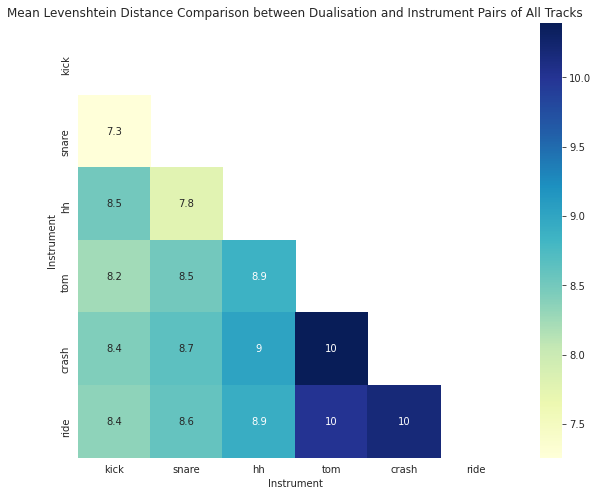

In [ ]:
# Plotting the heatmap of the mean distances
distance_matrix = [[1,1,1,1,1,1],\
           [mean_distances[0],1,1,1,1,1],\
           [mean_distances[1],mean_distances[5],1,1,1,1],\
           [mean_distances[2],mean_distances[6],mean_distances[9],1,1,1],\
           [mean_distances[3],mean_distances[7],mean_distances[10],mean_distances[12],1,1],\
           [mean_distances[4],mean_distances[8],mean_distances[11],mean_distances[13],mean_distances[14],1]\
           ]

participants = ['kick','snare','hh','tom','crash','ride']
mask = np.zeros_like(distance_matrix)
mask[np.triu_indices_from(mask)] = np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    
    ax = sns.heatmap(distance_matrix, mask=mask, xticklabels=participants, yticklabels=participants,\
                     square=True, annot=True, cmap="YlGnBu")
plt.xlabel('Instrument')
plt.ylabel('Instrument')
plt.title('Mean Levenshtein Distance Comparison between Dualisation and Instrument Pairs of All Tracks')
plt.show()

## Comparison per style

In [ ]:
# Differenciating the instrument by styles
df_one_rep_exp = pd.read_csv('../repetition experiment/one_hour_session.csv')
df_one_rep_exp = df_one_rep_exp.sort_values(by=['style']).drop_duplicates(subset='file_name')
df_one_rep_exp

df_dict_by_style = {
    'afrobeat': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'afrobeat'],
    'afrocuban': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'afrocuban'],
    'dance': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'dance'],
    'funk': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'funk'],
    'hiphop': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'hiphop'],
    'jazz': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'jazz'],
    'latin': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'latin'],
    'neworleans': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'neworleans'],
    'pop': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'pop'],
    'punk': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'punk'],
    'reggae': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'reggae'],
    'rock': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'rock'],
    'soul': df_one_rep_exp.loc[df_one_rep_exp['style'] == 'soul']
}


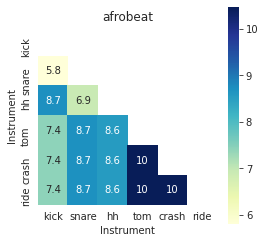

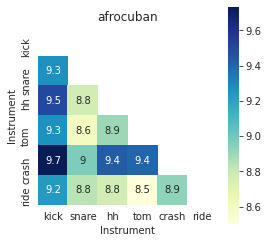

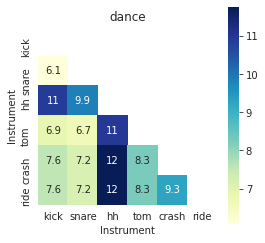

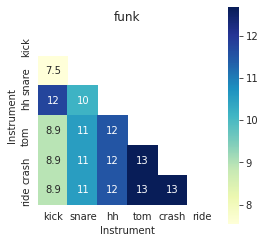

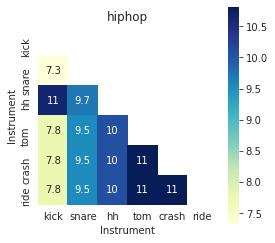

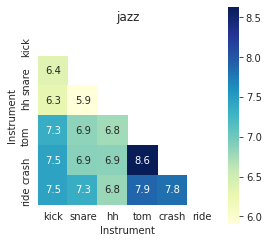

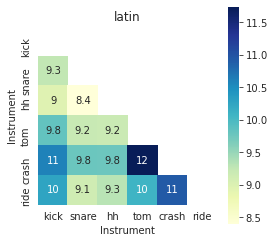

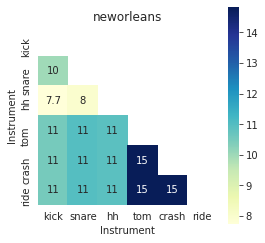

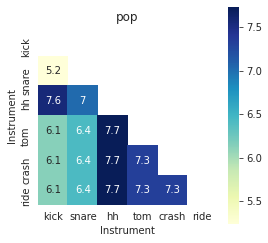

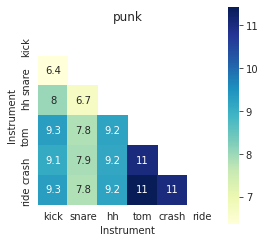

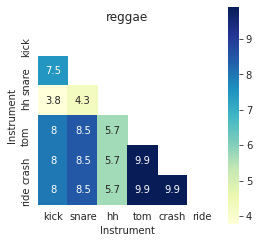

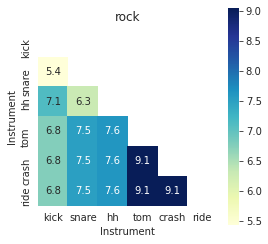

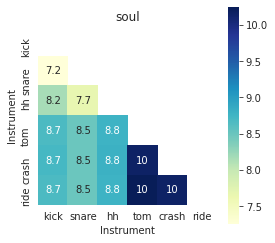

In [ ]:
#soul_df.iloc[0].file_name.split('\\')[-1].split('.')[0]

def get_mean_distance_from_style(style):
  '''
  This function is a modification of the above mean distance calculation; 
  it is sorted by style and not doing all tracks at once.
  The heatmap of the distances are also plotted.
  '''
  df_style = df_dict_by_style[style]

  track_list = []
  for index, row in df_style.iterrows():
    track_list.append(row['file_name'].split('\\')[-1].split('.')[0])

  mean_distances = []
  for distance_dict in distance_dictionaries:
    distance_extended = []
    for track in track_list:
      distance_extended.extend(distance_dict[track])

    # mean_distances.append(sum(distance_extended) / len(distance_extended))
    distance_extended_no_nan = [x for x in distance_extended if str(x) != 'nan']
    mean_distances.append(sum(distance_extended_no_nan) / len(distance_extended_no_nan))

  distance_matrix = [[1,1,1,1,1,1],\
            [mean_distances[0],1,1,1,1,1],\
            [mean_distances[1],mean_distances[5],1,1,1,1],\
            [mean_distances[2],mean_distances[6],mean_distances[9],1,1,1],\
            [mean_distances[3],mean_distances[7],mean_distances[10],mean_distances[12],1,1],\
            [mean_distances[4],mean_distances[8],mean_distances[11],mean_distances[13],mean_distances[14],1]\
            ]

  participants = ['kick','snare','hh','tom','crash','ride']
  mask = np.zeros_like(distance_matrix)
  mask[np.triu_indices_from(mask)] = np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
  with sns.axes_style("white"):
      f, ax = plt.subplots(figsize=(4,4))
      
      ax = sns.heatmap(distance_matrix, mask=mask, xticklabels=participants, yticklabels=participants,\
                      square=True, annot=True, cmap="YlGnBu")
  plt.xlabel('Instrument')
  plt.ylabel('Instrument')
  plt.title(style)
  plt.show()

# Getting the heatmap for every style
style_list = ['afrobeat','afrocuban','dance','funk','hiphop','jazz','latin','neworleans','pop','punk','reggae','rock','soul']
for style in style_list:

  get_mean_distance_from_style(style)

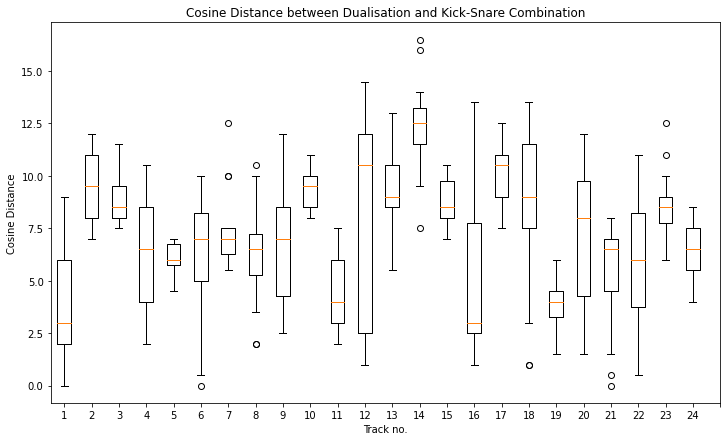

In [ ]:
data = [kick_snare_distance[track] for track in unique_files_tested_from_gmd]
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Cosine Distance between Dualisation and Kick-Snare Combination')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24'])
plt.xlabel('Track no.')
plt.ylabel('Cosine Distance')
plt.show()

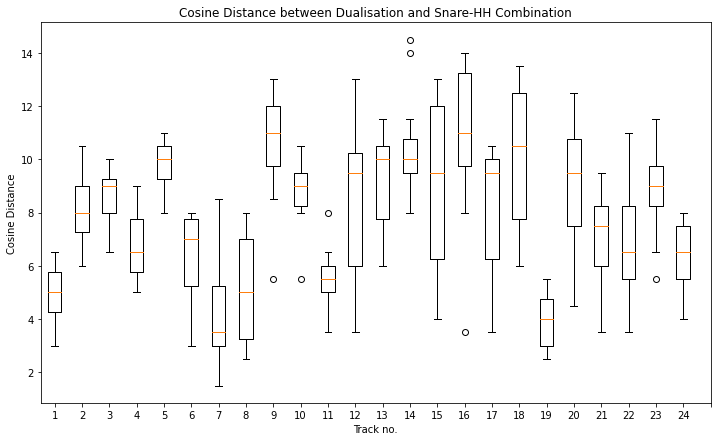

In [ ]:
data = [snare_hh_distance[track] for track in unique_files_tested_from_gmd]
fig4, ax4 = plt.subplots(figsize=(12,7))
ax4.set_title('Cosine Distance between Dualisation and Snare-HH Combination')
ax4
ax4.boxplot(data)
plt.xticks(index,['1','2','3','4','5','6','7','8','9','10',\
                  '11','12','13','14','15','16','17','18','19','20',\
                  '21','22','23','24'])
plt.xlabel('Track no.')
plt.ylabel('Cosine Distance')
plt.show()